## **Final Model Optimization, Evaluation, and Interpretation**

---
### **Author:** Mark Shumka

### **Contact:** markshumka@gmail.com

### **Date:** November 27, 2023
---

## **Table of Contents** ##
---
1. [Introduction](#1)
2. [Loading and Setup](#2)
3. [Additional Feature Engineering](#3)
4. [Modeling](#4)
    - [Logistic Regression](#4a)
    - [Support Vector Machine](#4b)
    - [Random Forest](#4c)
    - [XGBoost](#4d)
    - [Neural Network](#4e)
5. [Performance Evaluation](#5)
6. [Conclusion and Next Steps](#6)

## **Introduction** <a class="anchor" id="1"></a>

In this notebook, I continue the work in [these](https://github.com/markshumka/NHL-Game-Predictor/blob/main/Notebooks/Initial_data_upload_and_EDA.ipynb) [previous](https://github.com/markshumka/NHL-Game-Predictor/blob/main/Notebooks/Preprocessing_EDA_basic_model_creation.ipynb) notebooks. As a reminder, here is the problem statement I am addressing:

***Can we use data science to analyze past results of National Hockey League games and accurately predict the outcome of future games?***

Previously, I sourced data from the 2008-09 season through the 2022-23 season, a total of over 17,000 games. The data contains a combination of basic statistics provided by the NHL and advanced statistics, which are statistics derived from the basic statistics by analysts seeking to uncover additional predictive power of the basic data. In my case, I have sourced these advanced statistics from [Moneypuck.com](https://moneypuck.com/data.htm). I cleaned and performed EDA on the data, then ran initial models to establish a performance baseline. Hockey game outcomes are notoriously hard to predict due to the fast pace, constant shifting of players, relatively low scoring totals, and degree of randomness. The best published models only achieve accuracies in the low-60% range. Given that the home team wins ~54% of games, there is a very small window in which to demonstrate effective predictive abilities of a model. This was confirmed by my baseline models, which achieved accuracies of 56% - 57% at best. This notebook will attempt to improve on that.

## **Loading and Setup** <a class="anchor" id="2"></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, log_loss, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import time
import pickle
import os
# Filter warnings
from warnings import filterwarnings
filterwarnings('ignore')

I will upload the final dataset I created in the last workbook, which contains the basic and advanced stats I have been using, along with derived variables I built that aggregate data from the trailing 10 games.

In [3]:
# Import dataset
df = pd.read_csv('engineered_df_data4.csv')

In [150]:
df

,team_x,season,gameId,opposingTeam,gameDate,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,...,mean_rolling10_TakeawayPercentage_opp,mean_rolling10_TakeawayRatio_opp,mean_rolling10_FaceoffPercentage_opp,mean_rolling10_powerPlayPercentage_opp,mean_rolling10_penaltyKillPercentage_opp,mean_rolling10_shotEfficiency_opp,mean_rolling10_defensiveEfficiency_opp,goalPercentage,sum_rolling10_goalPercentage,sum_rolling10_goalPercentage_opp
0,NYR,2008,2008020001,TBL,2008-10-04,0.4596,0.6408,0.6310,37.733,2.287,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,NaN,NaN
1,NYR,2008,2008020003,TBL,2008-10-05,0.6619,0.6207,0.6190,34.277,1.793,...,0.366667,0.611111,0.516129,0.000000,0.857143,0.371885,0.874508,0.666667,0.666667,0.333333
2,NYR,2008,2008020010,CHI,2008-10-10,0.4123,0.4904,0.4643,27.924,1.938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,1.333333,NaN
3,NYR,2008,2008020019,PHI,2008-10-11,0.5008,0.5000,0.4810,27.100,3.030,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,2.000000,NaN
4,NYR,2008,2008020034,NJD,2008-10-13,0.3114,0.4369,0.4507,21.917,1.562,...,0.402778,0.579545,0.520225,0.125000,0.791667,0.806900,0.444285,0.800000,2.571429,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,LAK,2020,2020020852,COL,2021-05-07,0.3439,0.2990,0.3000,15.565,1.480,...,0.450737,0.437904,0.507448,0.193333,0.755000,1.114205,1.295629,0.400000,4.766667,5.292460
35340,LAK,2020,2020020867,COL,2021-05-08,0.3911,0.4624,0.4412,21.386,1.477,...,0.434070,0.415845,0.511200,0.193333,0.780000,1.054600,1.382408,0.400000,4.916667,5.225794
35341,LAK,2020,2020020456,STL,2021-05-10,0.4096,0.5556,0.5758,26.226,1.735,...,0.544158,0.458564,0.529294,0.328333,0.890000,1.408280,1.030832,0.333333,4.516667,5.192460
35342,LAK,2020,2020020688,COL,2021-05-12,0.1459,0.3761,0.3210,17.798,0.760,...,0.442404,0.444722,0.515849,0.173333,0.850000,1.010545,1.309808,0.000000,4.516667,5.254365


As a potential late addition to the model, I have sourced some basic goalie data to try to move the accuracy needle. As a reminder, the modeling done to-date has been at a team level, with no reference to individual players. I have considered including goalie data because I believe that which of the team's goalies (starter vs. backup) plays a game can significantly alter the likelihood of victory. The dataset that I have sourced simply includes the player ID of the goalie that played in every game; I can then use this to calculate and aggregate the stats for each goalie, and apply their specific historical data aggregation variables to games they play.

In [4]:
# Import goalie dataset
goalie_df = pd.read_csv('goalie_data.csv')

In [209]:
goalie_df

,Season,Game ID,Date,Team,Player_Id,Is_Home,Name,Position
0,20082009,2008020001,10/4/2008,NYR,8468685,0,Henrik Lundqvist,G
1,20082009,2008020001,10/4/2008,TBL,8469608,1,Mike Smith,G
2,20082009,2008020002,10/4/2008,OTT,8469675,1,Martin Gerber,G
3,20082009,2008020002,10/4/2008,PIT,8470594,0,Marc-Andre Fleury,G
4,20082009,2008020003,10/5/2008,TBL,8448535,0,Olie Kolzig,G
...,...,...,...,...,...,...,...,...
40763,20222023,2022021310,4/13/2023,LAK,8476914,0,Joonas Korpisalo,G
40764,20222023,2022021311,4/13/2023,ARI,8478872,1,Karel Vejmelka,G
40765,20222023,2022021311,4/13/2023,VAN,8480420,0,Collin Delia,G
40766,20222023,2022021312,4/13/2023,SEA,8475831,1,Philipp Grubauer,G


In [5]:
# create replacement dictionary, then replace in 'team' and 'opposingTeam' columns
replace_dict = {'N.J': 'NJD', 'T.B': 'TBL', 'S.J': 'SJS', 'L.A': 'LAK', 'PHX': 'ARI'}
goalie_df['Team'] = goalie_df['Team'].replace(replace_dict)

There are times when a team plays more than one goalie in a game, whether because of injury or because the starting goalie is having a bad game. My dataset can only support a single entry for each game, so I will exclude anything beyond the first goalie in a game from my dataset. This is not a perfect solution, but given that I am trying to determine the impact of the starting goalie on the game's outcome, it should provide some insight.

In [6]:
goalie_df = goalie_df.drop_duplicates(subset=['Game ID', 'Team'], keep='first')

In [157]:
goalie_df

,Season,Game ID,Date,Team,Player_Id,Is_Home,Name,Position
0,20082009,2008020001,10/4/2008,NYR,8468685,0,Henrik Lundqvist,G
1,20082009,2008020001,10/4/2008,TBL,8469608,1,Mike Smith,G
2,20082009,2008020002,10/4/2008,OTT,8469675,1,Martin Gerber,G
3,20082009,2008020002,10/4/2008,PIT,8470594,0,Marc-Andre Fleury,G
4,20082009,2008020003,10/5/2008,TBL,8448535,0,Olie Kolzig,G
...,...,...,...,...,...,...,...,...
40763,20222023,2022021310,4/13/2023,LAK,8476914,0,Joonas Korpisalo,G
40764,20222023,2022021311,4/13/2023,ARI,8478872,1,Karel Vejmelka,G
40765,20222023,2022021311,4/13/2023,VAN,8480420,0,Collin Delia,G
40766,20222023,2022021312,4/13/2023,SEA,8475831,1,Philipp Grubauer,G


I will now merge the goalie data with the main dataset.

In [25]:
# Convert 'gameId' to object type in df
df['gameId'] = df['gameId'].astype(str)

# Print unique data types in the merging columns
print("df['gameId'] dtype:", df['gameId'].dtype)
print("goalie_df['Game ID'] dtype:", goalie_df['Game ID'].dtype)

# Merge the dataframes based on 'gameId' and 'team_x'
df = df.merge(goalie_df[['Game ID', 'Team', 'Player_Id']].drop_duplicates(),
              left_on=['gameId', 'team_x'],
              right_on=['Game ID', 'Team'],
              how='left')

# Drop the additional columns used for merging
df = df.drop(['Game ID', 'Team'], axis=1)

# Display the updated dataframe
df

df['gameId'] dtype: object
goalie_df['Game ID'] dtype: object


,team_x,season,gameId,opposingTeam,gameDate,xGoalsPercentage,corsiPercentage,fenwickPercentage,xOnGoalFor,xGoalsFor,...,w_wins,w_win%,w_TakeawayRatio,w_dZoneGiveaway%,w_highDangerShotsRatio,w_HDSRatio,sum_season_goals,sum_season_goalsAgainst,seasonGoalDiff,Player_Id
0,NYR,2008,2008020001,TBL,2008-10-04,0.4596,0.6408,0.6310,37.733,2.287,...,0.000000,0.000000,0.531563,0.501730,0.076365,0.076365,NaN,NaN,0.0,8468685.0
1,NYR,2008,2008020003,TBL,2008-10-05,0.6619,0.6207,0.6190,34.277,1.793,...,1.000000,1.000000,0.531563,0.501730,0.076365,0.076365,2.0,1.0,1.0,8468685.0
2,NYR,2008,2008020010,CHI,2008-10-10,0.4123,0.4904,0.4643,27.924,1.938,...,1.000000,1.000000,0.531563,0.501730,0.076365,0.076365,4.0,2.0,2.0,8468685.0
3,NYR,2008,2008020019,PHI,2008-10-11,0.5008,0.5000,0.4810,27.100,3.030,...,1.000000,1.000000,0.531563,0.501730,0.076365,0.076365,8.0,4.0,4.0,8465161.0
4,NYR,2008,2008020034,NJD,2008-10-13,0.3114,0.4369,0.4507,21.917,1.562,...,1.000000,1.000000,0.531563,0.501730,0.076365,0.076365,12.0,7.0,5.0,8468685.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,LAK,2020,2020020852,COL,2021-05-07,0.3439,0.2990,0.3000,15.565,1.480,...,0.426848,0.426848,0.326373,0.600560,0.083511,0.083511,137.0,150.0,-13.0,8477361.0
35340,LAK,2020,2020020867,COL,2021-05-08,0.3911,0.4624,0.4412,21.386,1.477,...,0.410740,0.410740,0.325374,0.593596,0.084277,0.084277,139.0,153.0,-14.0,8477361.0
35341,LAK,2020,2020020456,STL,2021-05-10,0.4096,0.5556,0.5758,26.226,1.735,...,0.395528,0.395528,0.319803,0.583288,0.082284,0.082284,141.0,156.0,-15.0,8477361.0
35342,LAK,2020,2020020688,COL,2021-05-12,0.1459,0.3761,0.3210,17.798,0.760,...,0.381145,0.381145,0.316790,0.584646,0.080707,0.080707,142.0,158.0,-16.0,8477361.0


## **Addtional Feature Engineering** <a class="anchor" id="3"></a>

In the previous exercise, I concluded that I needed to build variables that aggregate past performance so that I can have inputs to a model to predict future performance. While the entire dataset included past performance data, that data was specific to the game in which it occurred. With that, I could build a very accurate model to determine the winner of a game, but only if I had the statistics from that particular game. This is not useful for predicting future outcomes.

To address this, I built variables that combined the data from the prior 10 games into single pregame variables for each feature. I determined that performance over the past 10 games can be used to predict future results, but the 10 game rolling window was arbitrary, and I wanted to see if other windows would perform better. I started building models that looked at the whole season.

In [9]:
# season-to-date goal totals (using .expanding instead of .rolling)
df['sum_season_goals'] = df.groupby(['team_x', 'season'])['goals'].transform(lambda x: x.expanding().sum().shift())

In [10]:
# season-to-date goals against totals (using .expanding instead of .rolling)
df['sum_season_goalsAgainst'] = df.groupby(['team_x', 'season'])['goalsAgainst'].transform(lambda x: x.expanding().sum().shift())

In [11]:
# season-to-date goal differential totals (using .expanding instead of .rolling)
df['seasonGoalDiff'] = df['sum_season_goals'] - df['sum_season_goalsAgainst']

The goal differential stat in particular felt useful. Hockey fans can tell you that the season-to-date goal differential is usually a very good indicator of a team's position in the standings, and the end-of-season results can typically be sorted by goal differential and give a close approximation to the actual standings. However, applying this full season methodology to any other statistic felt like it placed too much weight on games in the distant past. What does it matter how many blocked shots a team had in the first game of the season when we are trying to predict the outcome of the 80th game?

Rather than using the full season, I could simply expand the window of the rolling game average, from 10 games to any number larger. But that felt arbitrary, and incorporated no decay on the importance of earlier games. While I can justify the past 10 games as indicative of the current level of play, anything earlier than that doesn't "feel" directly predictive. In fact, is 10 even the right number to start with? Would five games be better? Three? Of course, I could test this using every number of games as the window of my historical variables, but this would take a long time, with no guarantee that it would produce better results.

Fortunately, other people have faced this conundrum and tested various scenarios, so I could learn from their efforts. Here is a quote from [Moneypuck.com's](https://moneypuck.com/about.htm) description of how they built their prediction model:

*"The data used to predict each game includes each team's performance of a range of statistics in the season up until the date of the given game. Older games are given less weighting for the statistic. The weighting each game is given is linear. For example, when predicting the result of a team's 41st game of the season, the team's 40th game is given twice the weight as a team's 20th game. Several game weighting techniques were tested as part of building the model, from weighting each game equally to weighting recent games exponentially more. Also, using just the last 20 or 30 games data was evaluated in combination with each one of these methods. Ultimately, using full season to date data with a linear decay of game importance showed to have the most predictive power."*

This convinced me that there wasn't an obvious benefit to increasing the rolling game window to 20+ games, but it also suggested that including full-season information, with a formula to give higher weight to more recent games, had predictive power. This feels intuitively satisfying, as a team's performance seems to be the culmination of all the games leading up to that game. Teams that are doing well will typically continue to do well, and teams that are doing poorly will typically continue to do poorly.

I set about building weighted season-to-date variables, using a linear decay model. Here is a visual representation of what that weighting would look like over an 82-game season:

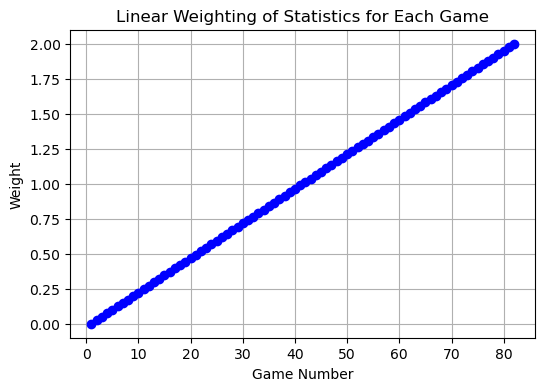

In [19]:
# Define the number of games in the season
num_games = 82

# Calculate the weights for each game
weights = [2 * i / (num_games - 1) for i in range(num_games)]

# Create a line plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_games + 1), weights, marker='o', linestyle='-', color='b')
plt.title('Linear Weighting of Statistics for Each Game')
plt.xlabel('Game Number')
plt.ylabel('Weight')
plt.grid(True)
plt.show()

Here's a visualization of how that would apply to actual data. Specifically, this graph shows the actual goals scored by the Vancouver Canucks in the 2022-23 season, and adds a line displaying the rolling 10-game average and the weighted season-to-date average:

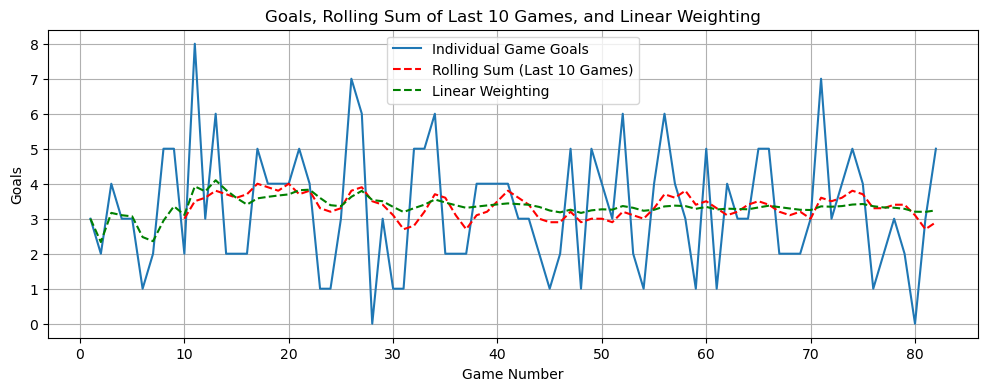

In [49]:
# Actual data
goals = [3, 2, 4, 3, 3, 1, 2, 5, 5, 2, 8, 3, 6, 2, 2, 2, 5, 4, 4, 4, 5, 4, 1, 1, 3, 7, 6, 0, 3, 1, 1, 5, 5, 6, 2, 2, 2, 4, 4, 4, 4, 3, 3, 2, 1, 2, 5, 1, 5, 4, 3, 6, 2, 1, 4, 6, 4, 3, 1, 5, 1, 4, 3, 3, 5, 5, 2, 2, 2, 3, 7, 3, 4, 5, 4, 1, 2, 3, 2, 0, 3, 5]

# Calculate rolling sum of last 10 games
rolling_sum_last_10 = np.convolve(goals, np.ones(10)/10, mode='valid')

# Linear weighting values
linear_weighting_values = [3, 2.333333333, 3.166666667, 3.1, 3.066666667, 2.476190476, 2.357142857, 2.944444444, 3.355555556, 3.109090909, 3.924242424, 3.782051282, 4.098901099, 3.819047619, 3.591666667, 3.404411765, 3.581699346, 3.625730994, 3.663157895, 3.695238095, 3.813852814, 3.830039526, 3.594202899, 3.386666667, 3.356923077, 3.626780627, 3.796296296, 3.534482759, 3.498850575, 3.337634409, 3.191532258, 3.301136364, 3.401069519, 3.549579832, 3.463492063, 3.384384384, 3.311522048, 3.34682861, 3.379487179, 3.409756098, 3.43786295, 3.417497231, 3.398520085, 3.336363636, 3.234782609, 3.182238668, 3.257978723, 3.165816327, 3.239183673, 3.269019608, 3.2586727, 3.362119013, 3.311670161, 3.227609428, 3.255194805, 3.351503759, 3.373865699, 3.361192285, 3.282485876, 3.338797814, 3.263352723, 3.286738351, 3.277777778, 3.269230769, 3.321678322, 3.371777476, 3.33143108, 3.292838875, 3.255900621, 3.248692153, 3.352895149, 3.343226788, 3.360977416, 3.404684685, 3.420350877, 3.357484621, 3.322677323, 3.314508277, 3.28164557, 3.200617284, 3.195724179, 3.239200705]

# Create a line plot
plt.figure(figsize=(12, 4))
plt.plot(range(1, len(goals) + 1), goals, linestyle='-', label='Individual Game Goals')
plt.plot(range(10, len(goals) + 1), rolling_sum_last_10, linestyle='--', color='r', label='Rolling Sum (Last 10 Games)')
plt.plot(range(1, len(goals) + 1), linear_weighting_values, linestyle='--', color='g', label='Linear Weighting')

plt.title('Goals, Rolling Sum of Last 10 Games, and Linear Weighting')
plt.xlabel('Game Number')
plt.ylabel('Goals')
plt.legend()
plt.grid(True)
plt.show()

While I knew conceptually what I wanted, I had to figure out how to build it. After some research, I discovered numpy's `linspace` function, which returns a number of evenly spaced samples, calculated over the interval. Grouping by `season`, I could use the length of the season-to-date as the inputs for `linspace`.

In [13]:
df['weighted_mean_season_goals_shifted'] = df.groupby(['team_x', 'season'])['goals'].apply(
    lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
).shift()


In [ ]:
df['weighted_mean_season_goals_shifted'].head()

That seems to work. However, another comment from moneypuck about how their model is built questions some of the validity of this methodology: "each team's first 20 games of each season are not used". This echoes a challenge I had with the trailing 10 games methodology: how to handle the first games of a season, when there is not enough data to have confidence? I decided to use the final value of the previous season to replace the first 10 game values of the weighted model. Again, I could test multiple iterations, but this feels like a good compromise as a starting point. While some teams may experience a lot of change between seasons, the end of the previous season is the best data we have available to predict the start of the current season. 

If all of the above assumptions proved invalid, and the new variables underperform the 56% - 57% accuracy I was achieving with 10-game rolling averages, I will revisit the variable calculations.

In [14]:
# Function to replace the first 10 values in a group with the first value
def replace_first_10(group):
    first_value = group.iloc[0]
    group.iloc[1:10] = first_value
    return group

# Apply the function to each group defined by 'team_x' and 'season'
df['weighted_mean_season_goals_shifted'] = df.groupby(['team_x', 'season'])['weighted_mean_season_goals_shifted'].apply(replace_first_10)

# Display the result
print(df[['team_x', 'season', 'goals', 'weighted_mean_season_goals_shifted']])


      team_x  season  goals  weighted_mean_season_goals_shifted
0        NYR    2008    2.0                                 NaN
1        NYR    2008    2.0                                 NaN
2        NYR    2008    4.0                                 NaN
3        NYR    2008    4.0                                 NaN
4        NYR    2008    4.0                                 NaN
...      ...     ...    ...                                 ...
35339    LAK    2020    2.0                            2.552036
35340    LAK    2020    2.0                            2.531205
35341    LAK    2020    1.0                            2.511530
35342    LAK    2020    0.0                            2.456566
35343    LAK    2020    1.0                            2.368831

[35344 rows x 4 columns]


I still have some `NaN` values in there: the first 10 games of the first season in the dataset. I'm not too worried about this, as it represents <0.1% of the data, so I will replace it with the season average for the first year. I can now apply the logic to all of the relevant columns.

Now I can apply that logic to all the relevant columns.

In [ ]:
# List of columns to apply the logic to
columns_to_process = [
    'xGoalsPercentage', 'corsiPercentage', 'fenwickPercentage',
    'xGoalsFor', 'flurryAdjustedxGoalsFor', 'scoreVenueAdjustedxGoalsFor',
    'flurryScoreVenueAdjustedxGoalsFor', 'shotsOnGoalFor', 'blockedShotAttemptsFor',
    'shotAttemptsFor', 'goalsFor', 'savedShotsOnGoalFor', 'faceOffsWonFor',
    'hitsFor', 'takeawaysFor', 'giveawaysFor', 'lowDangerShotsFor',
    'mediumDangerShotsFor', 'highDangerShotsFor', 'lowDangerxGoalsFor',
    'mediumDangerxGoalsFor', 'highDangerxGoalsFor', 'lowDangerGoalsFor',
    'mediumDangerGoalsFor', 'scoreAdjustedShotsAttemptsFor',
    'unblockedShotAttemptsFor', 'scoreAdjustedUnblockedShotAttemptsFor',
    'dZoneGiveawaysFor', 'totalShotCreditFor', 'scoreAdjustedTotalShotCreditFor',
    'scoreFlurryAdjustedTotalShotCreditFor', 'xGoalsAgainst',
    'flurryAdjustedxGoalsAgainst', 'scoreVenueAdjustedxGoalsAgainst',
    'flurryScoreVenueAdjustedxGoalsAgainst', 'shotsOnGoalAgainst',
    'blockedShotAttemptsAgainst', 'shotAttemptsAgainst', 'goalsAgainst',
    'savedShotsOnGoalAgainst', 'faceOffsWonAgainst', 'hitsAgainst',
    'takeawaysAgainst', 'giveawaysAgainst', 'lowDangerShotsAgainst',
    'mediumDangerShotsAgainst', 'highDangerShotsAgainst', 'lowDangerxGoalsAgainst',
    'mediumDangerxGoalsAgainst', 'highDangerxGoalsAgainst', 'lowDangerGoalsAgainst',
    'mediumDangerGoalsAgainst', 'highDangerGoalsAgainst',
    'scoreAdjustedShotsAttemptsAgainst', 'unblockedShotAttemptsAgainst',
    'scoreAdjustedUnblockedShotAttemptsAgainst', 'dZoneGiveawaysAgainst',
    'totalShotCreditAgainst', 'scoreAdjustedTotalShotCreditAgainst',
    'scoreFlurryAdjustedTotalShotCreditAgainst', 'goals', 'powerPlayOpportunities',
    'powerPlayGoals', 'goalDifferential'
]

# Calculate weighted season average using linear decay for each column
for col in columns_to_process:
    df[f'weighted_{col}'] = df.groupby(['team_x', 'season'])[col].apply(
        lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
    ).shift()

    # Function to replace the first 10 values in a group with the first value
    def replace_first_10(group):
        first_value = group.iloc[0]
        group.iloc[1:10] = first_value
        team_season_avg = group[f'weighted_{col}'].mean()
        group = group.fillna({f'weighted_{col}': team_season_avg})
        return group

    # Apply the function to each group defined by 'team_x' and 'season'
    df[f'weighted_{col}'] = df.groupby(['team_x', 'season']).apply(replace_first_10)[f'weighted_{col}']


I also initially created some share and ratio calculated variables. I cannot simply apply the season-to-date weighting to those variables, as it would mean taking the average of averages. Instead, I will use the weighted components of the calculations to create new calculations.

In [ ]:
# Weighted goals percentage calcuation
df['weighted_goalsPercentage_calc'] = df['weighted_goals'] / (df['weighted_goals'] + df['weighted_goalsAgainst'])

In [ ]:
# List of columns for the calculation
columns_to_calculate = [
    'goals', 'goalsAgainst',
    'highDangerShotsFor', 'highDangerShotsAgainst',
    'dZoneGiveawaysFor', 'dZoneGiveawaysAgainst',
    'takeawaysFor', 'takeawaysAgainst',
    'giveawaysFor', 'giveawaysAgainst',
    'xGoalsFor', 'xGoalsAgainst',
    'flurryAdjustedxGoalsFor', 'flurryAdjustedxGoalsAgainst',
    'scoreVenueAdjustedxGoalsFor', 'scoreVenueAdjustedxGoalsAgainst',
    'flurryScoreVenueAdjustedxGoalsFor', 'flurryScoreVenueAdjustedxGoalsAgainst',
    'shotsOnGoalFor', 'shotsOnGoalAgainst',
    'blockedShotAttemptsFor', 'blockedShotAttemptsAgainst',
    'shotAttemptsFor', 'shotAttemptsAgainst',
    'faceOffsWonFor', 'faceOffsWonAgainst',
    'hitsFor', 'hitsAgainst',
    'unblockedShotAttemptsFor', 'unblockedShotAttemptsAgainst',
    'scoreAdjustedShotsAttemptsFor', 'scoreAdjustedShotsAttemptsAgainst',
    'scoreAdjustedUnblockedShotAttemptsFor', 'scoreAdjustedUnblockedShotAttemptsAgainst'
]

# Perform the calculation for each column
for col in columns_to_calculate:
    df[f'weighted_{col}_calc'] = df[f'weighted_{col}'] / (df[f'weighted_{col}'] + df[f'weighted_{col.replace("For", "Against").replace("Against", "For")}'])


In [ ]:
# List of columns for the calculation
columns_to_calculate = [
    'highDangerShotsFor',
    'dZoneGiveawaysFor',
    'takeawaysFor',
    'giveawaysFor',
    'xGoalsFor',
    'flurryAdjustedxGoalsFor',
    'scoreVenueAdjustedxGoalsFor',
    'flurryScoreVenueAdjustedxGoalsFor',
    'shotsOnGoalFor',
    'blockedShotAttemptsFor',
    'shotAttemptsFor',
    'faceOffsWonFor',
    'hitsFor',
    'unblockedShotAttemptsFor',
    'scoreAdjustedShotsAttemptsFor',
    'scoreAdjustedUnblockedShotAttemptsFor'
]

# Perform the calculation for each column
for col in columns_to_calculate:
    df[f'weighted_{col}Diff'] = df[f'weighted_{col}'] - df[f'weighted_{col.replace("For", "Against")}']


I mentioned above that I added the ability to include data on individual goalies. I will now build the goalie variables to include. For `NaN` values, I will simply replace the field with the overall team average for that game. While this is not perfect, it should provide variables that are much closer to the specific goalie's statistics than the general team statistics.

In [ ]:
# Expected Goals Against
df['GoaliexGA'] = df.groupby(['Player_Id', 'season'])['xGoalsAgainst'].apply(
    lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
).shift()

# Replace NaN values in 'GoaliexGA' with values from 'weighted_xGoalsAgainst'
df['GoaliexGA'].fillna(df['weighted_xGoalsAgainst'], inplace=True)

In [ ]:
# Goals Against
df['GoalieGA'] = df.groupby(['Player_Id', 'season'])['goalsAgainst'].apply(
    lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
).shift()

# Replace NaN values in 'GoalieGA' with values from 'weighted_GoalsAgainst'
df['GoalieGA'].fillna(df['weighted_goalsAgainst'], inplace=True)

In [ ]:
# Shots on Goal
df['GoalieShots'] = df.groupby(['Player_Id', 'season'])['shotsOnGoalAgainst'].apply(
    lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
).shift()

# Replace NaN values in 'GoalieShots' with values from 'weighted_shotsOnGoalAgainst'
df['GoalieShots'].fillna(df['weighted_shotsOnGoalAgainst'], inplace=True)

In [ ]:
# Saves above expected
df['GoalieSAR'] = df['GoaliexGA'] - df['GoalieGA']

In [ ]:
# Save Percentage
df['GoalieSave%'] = (df['GoalieShots'] - df['GoalieGA']) / df['GoalieShots']

In [ ]:
df

In [91]:
df.to_csv('testing_data5.csv', index=False)

In [92]:
df = pd.read_csv('testing_data2.csv')

After reviewing the new dataframe, there are a number of variables that weren't included in the above variable creation, either because they have calculations specific to the variable or because I missed them! Below is ad hoc creation of those variables.

In [184]:
# Weighted blocks calcuation
df['w_blocks%'] = df['weighted_blockedShotAttemptsAgainst'] / (df['weighted_blockedShotAttemptsFor'] + df['weighted_blockedShotAttemptsAgainst'])

In [185]:
# Weighted blocks diff
df['w_blocksDiff'] = df['weighted_blockedShotAttemptsAgainst'] - df['weighted_blockedShotAttemptsFor']

In [186]:
# Weighted PP%
df['w_PP%'] = df['weighted_powerPlayGoals'] / df['weighted_powerPlayOpportunities']

In [187]:
# calculate weighted season average using linear decay
df['weighted_shorthanded'] = df.groupby(['team_x', 'season'])['shorthanded'].apply(
    lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
).shift()

# Function to replace the first 10 values in a group with the first value
def replace_first_10(group):
    first_value = group.iloc[0]
    group.iloc[1:10] = first_value
# use the season average for NaN values in the first season
    team_season_avg = group['weighted_shorthanded'].mean()
    group = group.fillna({'weighted_shorthanded': team_season_avg})    
    return group

# Apply the function to each group defined by 'team_x' and 'season'
df['weighted_shorthanded'] = df.groupby(['team_x', 'season']).apply(replace_first_10)['weighted_shorthanded']


In [188]:
# calculate weighted season average using linear decay
df['weighted_powerPlayGoalsAgainst'] = df.groupby(['team_x', 'season'])['powerPlayGoalsAgainst'].apply(
    lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
).shift()

# Function to replace the first 10 values in a group with the first value
def replace_first_10(group):
    first_value = group.iloc[0]
    group.iloc[1:10] = first_value
# use the season average for NaN values in the first season
    team_season_avg = group['weighted_powerPlayGoalsAgainst'].mean()
    group = group.fillna({'weighted_powerPlayGoalsAgainst': team_season_avg})    
    return group

# Apply the function to each group defined by 'team_x' and 'season'
df['weighted_powerPlayGoalsAgainst'] = df.groupby(['team_x', 'season']).apply(replace_first_10)['weighted_powerPlayGoalsAgainst']


In [189]:
# Weighted PK%
df['w_PK%'] = (df['weighted_shorthanded'] - df['weighted_powerPlayGoalsAgainst']) / df['weighted_shorthanded']

In [190]:
# Weighted Save%
df['w_Save%'] = (df['weighted_shotsOnGoalAgainst'] - df['weighted_goalsAgainst']) / df['weighted_shotsOnGoalAgainst']

In [191]:
# Weighted Shooting%
df['w_Shooting%'] = df['weighted_goals'] / df['weighted_shotsOnGoalFor']

In [192]:
# Weighted Shot Efficiency
df['w_ShotEfficiency'] = df['weighted_goals'] / df['weighted_xGoalsFor']

In [193]:
# Weighted Shot Efficiency
df['w_DefEfficiency'] = df['weighted_goalsAgainst'] / df['weighted_xGoalsAgainst']

In [194]:
# Last 10 win %
df['last10win%'] = df['sum_rolling10_won'] / 10

In [195]:
# season-to-date win %
df['seasonWin%'] = df.groupby(['team_x', 'season'])['won'].transform(lambda x: x.expanding().mean().shift())

In [196]:
df['seasonWin%'].fillna(0, inplace=True)

In [197]:
df['w_win%'] = df.groupby(['team_x', 'season'])['won'].apply(
    lambda x: x.expanding().apply(lambda y: np.average(y, weights=np.linspace(1, len(y), len(y))))
).shift()

In [198]:
df['w_win%'].fillna(0, inplace=True)

In [199]:
df['w_TakeawayRatio'] = df['weighted_takeawaysFor'] / (df['weighted_takeawaysFor'] + df['weighted_giveawaysFor'])

In [200]:
df['w_dZoneGiveaway%'] = df['weighted_dZoneGiveawaysFor'] / (df['weighted_dZoneGiveawaysFor'] + df['weighted_dZoneGiveawaysAgainst'])

In [201]:
df['w_HDSRatio'] = df['weighted_highDangerShotsFor'] / df['weighted_shotsOnGoalFor']

In [202]:
df['seasonGoalDiff'].fillna(0, inplace=True)

In [42]:
df.to_csv('testing_data3.csv', index=False)

In [20]:
df = pd.read_csv('testing_data3.csv')

With all of the feature engineering over this and the previous rounds of analysis, the dataframe now has more than 400 columns. I can now create a new one that only includes the newly-created variables.

In [34]:
# List of columns to keep
selected_columns = [
    'team_x', 'season', 'gameId', 'opposingTeam', 'HoA', 'won', 'Days_Since_Last_Game',
    'back_to_back', 'Distance_Since_Last_Game', 'Distance_per_day', 'sum_rolling10_goals',
    'sum_rolling10_won', 'sum_rolling10_goaldiff', 'sum_rolling10_goalPercentage',
    'weighted_goals', 'weighted_xGoalsFor', 'weighted_flurryAdjustedxGoalsFor',
    'weighted_scoreVenueAdjustedxGoalsFor', 'weighted_flurryScoreVenueAdjustedxGoalsFor',
    'weighted_shotsOnGoalFor', 'weighted_hitsFor', 'weighted_takeawaysFor', 'weighted_giveawaysFor',
    'weighted_blockedShotAttemptsAgainst', 'weighted_goalDifferential',
    'weighted_highDangerShotsForPercentage_calc', 'weighted_dZoneGiveawaysForPercentage_calc',
    'weighted_takeawaysForPercentage_calc', 'weighted_giveawaysForPercentage_calc',
    'weighted_xGoalsForPercentage_calc', 'weighted_flurryAdjustedxGoalsForPercentage_calc',
    'weighted_scoreVenueAdjustedxGoalsForPercentage_calc',
    'weighted_flurryScoreVenueAdjustedxGoalsForPercentage_calc',
    'weighted_shotsOnGoalForPercentage_calc', 'weighted_shotAttemptsForPercentage_calc',
    'weighted_faceOffsWonForPercentage_calc', 'weighted_hitsForPercentage_calc',
    'weighted_unblockedShotAttemptsForPercentage_calc',
    'weighted_scoreAdjustedShotsAttemptsForPercentage_calc',
    'weighted_scoreAdjustedUnblockedShotAttemptsForPercentage_calc',
    'weighted_goalsPercentage_calc', 'weighted_highDangerShotsForDiff',
    'weighted_dZoneGiveawaysForDiff', 'weighted_takeawaysForDiff', 'weighted_giveawaysForDiff',
    'weighted_xGoalsForDiff', 'weighted_flurryAdjustedxGoalsForDiff',
    'weighted_scoreVenueAdjustedxGoalsForDiff', 'weighted_flurryScoreVenueAdjustedxGoalsForDiff',
    'weighted_shotsOnGoalForDiff', 'weighted_shotAttemptsForDiff', 'weighted_faceOffsWonForDiff',
    'weighted_hitsForDiff', 'weighted_unblockedShotAttemptsForDiff',
    'weighted_scoreAdjustedShotsAttemptsForDiff',
    'weighted_scoreAdjustedUnblockedShotAttemptsForDiff', 'seasonGoalDiff', 'w_HDSRatio',
    'w_dZoneGiveaway%', 'w_TakeawayRatio', 'w_win%', 'seasonWin%', 'last10win%', 'w_DefEfficiency',
    'w_ShotEfficiency', 'w_Shooting%', 'w_Save%', 'w_PK%', 'w_PP%', 'w_blocksDiff', 'w_blocks%', 'GoaliexGA',
    'GoalieGA', 'GoalieShots', 'GoalieSAR', 'GoalieSave%'
]

# Create a new DataFrame with only the selected columns
new_df = df[selected_columns].copy()

In [133]:
new_df

,team_x,season,gameId,opposingTeam,HoA,won,Days_Since_Last_Game,back_to_back,Distance_Since_Last_Game,Distance_per_day,...,w_Save%,w_PK%,w_PP%,w_blocksDiff,w_blocks%,GoaliexGA,GoalieGA,GoalieShots,GoalieSAR,GoalieSave%
0,NYR,2008,2008020001,TBL,0.0,1.0,10.0,0,0.00,0.000,...,0.911019,0.872865,0.143644,-3.318293,0.435226,2.732404,2.687805,30.206369,0.044599,0.911019
1,NYR,2008,2008020003,TBL,1.0,1.0,1.0,1,1620.13,1620.130,...,0.911019,0.872865,0.143644,-3.318293,0.435226,2.689000,1.000000,21.000000,1.689000,0.952381
2,NYR,2008,2008020010,CHI,1.0,1.0,5.0,0,0.00,0.000,...,0.911019,0.872865,0.143644,-3.318293,0.435226,1.507000,1.000000,19.666667,0.507000,0.949153
3,NYR,2008,2008020019,PHI,0.0,1.0,1.0,1,137.47,137.470,...,0.911019,0.872865,0.143644,-3.318293,0.435226,2.134500,1.500000,25.833333,0.634500,0.941935
4,NYR,2008,2008020034,NJD,1.0,1.0,2.0,0,137.47,68.735,...,0.911019,0.872865,0.143644,-3.318293,0.435226,3.020000,3.000000,28.000000,0.020000,0.892857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38043,LAK,2020,2020020852,COL,1.0,0.0,2.0,0,3938.91,1969.455,...,0.903324,0.833286,0.168237,1.158371,0.522584,2.880760,3.340726,32.453629,-0.459966,0.897062
38044,LAK,2020,2020020867,COL,1.0,0.0,1.0,1,3695.83,3695.830,...,0.904027,0.828610,0.165915,1.529753,0.529766,2.877320,3.320076,32.729167,-0.442756,0.898559
38045,LAK,2020,2020020456,STL,1.0,0.0,2.0,0,4171.69,2085.845,...,0.903883,0.821946,0.161374,1.436059,0.527971,2.843360,3.301248,32.568627,-0.457888,0.898637
38046,LAK,2020,2020020688,COL,0.0,0.0,2.0,0,2687.27,1343.635,...,0.903675,0.826788,0.156996,1.347475,0.525976,2.823797,3.226891,31.793277,-0.403094,0.898504


I can also simplify the naming of some of the columns.

In [220]:
# Mapping of old names to new names
column_mapping = {
    'team_x': 'team_x',
    'season': 'season',
    'gameId': 'gameId',
    'opposingTeam': 'opposingTeam',
    'HoA': 'home',
    'won': 'won',
    'Days_Since_Last_Game': 'days',
    'back_to_back': 'B2B',
    'Distance_Since_Last_Game': 'dist',
    'Distance_per_day': 'daydist',
    'sum_rolling10_goals': 'last10goals',
    'sum_rolling10_won': 'last10wins',
    'sum_rolling10_goaldiff': 'last10diff',
    'sum_rolling10_goalPercentage': 'last10goal%',
    'weighted_goals': 'w_goals',
    'weighted_xGoalsFor': 'w_xGoals',
    'weighted_flurryAdjustedxGoalsFor': 'w_FAxGoals',
    'weighted_scoreVenueAdjustedxGoalsFor': 'w_SVAxGoals',
    'weighted_flurryScoreVenueAdjustedxGoalsFor': 'w_FSVAxGoals',
    'weighted_shotsOnGoalFor': 'w_shots',
    'weighted_hitsFor': 'w_hits',
    'weighted_takeawaysFor': 'w_takeaways',
    'weighted_giveawaysFor': 'w_giveaways',
    'weighted_blockedShotAttemptsAgainst': 'w_blocks',
    'weighted_goalDifferential': 'w_goalDiff',
    'weighted_highDangerShotsForPercentage_calc': 'w_HDS%',
    'weighted_dZoneGiveawaysForPercentage_calc': 'w_dZgiveaways%',
    'weighted_takeawaysForPercentage_calc': 'w_takeaways%',
    'weighted_giveawaysForPercentage_calc': 'w_giveaways%',
    'weighted_xGoalsForPercentage_calc': 'w_xGoals%',
    'weighted_flurryAdjustedxGoalsForPercentage_calc': 'w_FAxGoals%',
    'weighted_scoreVenueAdjustedxGoalsForPercentage_calc': 'w_SVAxGoals%',
    'weighted_flurryScoreVenueAdjustedxGoalsForPercentage_calc': 'w_FSVAxGoals%',
    'weighted_shotsOnGoalForPercentage_calc': 'w_Shots%',
    'weighted_shotAttemptsForPercentage_calc': 'w_Corsi%',
    'weighted_faceOffsWonForPercentage_calc': 'w_FO%',
    'weighted_hitsForPercentage_calc': 'w_hits%',
    'weighted_unblockedShotAttemptsForPercentage_calc': 'w_Fenwick%',
    'weighted_scoreAdjustedShotsAttemptsForPercentage_calc': 'w_AdjCorsi%',
    'weighted_scoreAdjustedUnblockedShotAttemptsForPercentage_calc': 'w_AdjFenwick%',
    'weighted_goalsPercentage_calc': 'w_goals%',
    'weighted_highDangerShotsForDiff': 'w_HDSdiff',
    'weighted_dZoneGiveawaysForDiff': 'w_dZgiveawaysDiff',
    'weighted_takeawaysForDiff': 'w_takeawaysDiff',
    'weighted_giveawaysForDiff': 'w_giveawaysDiff',
    'weighted_xGoalsForDiff': 'w_xGoalsDiff',
    'weighted_flurryAdjustedxGoalsForDiff': 'w_FAxGoalsDiff',
    'weighted_scoreVenueAdjustedxGoalsForDiff': 'w_SVAxGoalsDiff',
    'weighted_flurryScoreVenueAdjustedxGoalsForDiff': 'w_FSVAxGoalsDiff',
    'weighted_shotsOnGoalForDiff': 'w_ShotsDiff',
    'weighted_shotAttemptsForDiff': 'w_CorsiDiff',
    'weighted_faceOffsWonForDiff': 'w_Fodiff',
    'weighted_hitsForDiff': 'w_hitsDiff',
    'weighted_unblockedShotAttemptsForDiff': 'w_FenwickDiff',
    'weighted_scoreAdjustedShotsAttemptsForDiff': 'wAdjCorsiDiff',
    'weighted_scoreAdjustedUnblockedShotAttemptsForDiff': 'wAdjFenwickDiff',
    'seasonGoalDiff': 'seasonGoalDiff',
    'w_HDSRatio': 'w_HDSRatio',
    'w_dZoneGiveaway%': 'w_dZoneGiveaway%',
    'w_TakeawayRatio': 'w_TakeawayRatio',
    'w_win%': 'w_win%',
    'seasonWin%': 'seasonWin%',
    'last10win%': 'last10win%',
    'w_DefEfficiency': 'w_DefEfficiency',
    'w_ShotEfficiency': 'w_ShotEfficiency',
    'w_Shooting%': 'w_Shooting%',
    'w_Save%': 'w_Save%',
    'w_PK%': 'w_PK%',
    'w_PP%': 'w_PP%',
    'w_blocksDiff': 'w_blocksDiff',
    'w_blocks%': 'w_blocks%',
    'GoalieShots': 'GoalieShots',
    'GoaliexGA': 'GoaliexGA',
    'GoalieGA': 'GoalieGA',
    'GoalieSAR': 'GoalieSAR',
    'GoalieSave%': 'GoalieSave%'
}

# Rename columns in new_df
new_df.rename(columns=column_mapping, inplace=True)


There is one more piece of data I want to add to the dataframe: the betting line, or odds. One way I have considered of evaluating the performance of the model is to analyze the Return-On_Investment (ROI) of betting on the winners predicted by the model. In order to calculate profitability, I need to know the payout for betting on each team in a game. I was able to locate a dataset that includes the betting line for all games from 2012 to 2022. While this does not cover the entirety of my dataset, I can still use it to evaluate performance over a significant number of actual games.

In [54]:
odds = pd.read_csv('odds.csv')
odds

,GameId,Team,Odds
0,2012020001,PHI,-110
1,2012020001,PIT,-110
2,2012020002,OTT,105
3,2012020002,WPG,-125
4,2012020003,CHI,105
...,...,...,...
22883,2021021310,VAN,-172
22884,2021021311,ARI,200
22885,2021021311,NSH,-220
22886,2021021312,SJS,116


The column I've called 'Odds' in that dataframe is actually referred to as the moneyline. It indicates the payout for bets on each team to win the game. For example, in the final game in the dataframe, GameId 2021021312, San Jose (SJS) is playing Seattle (SEA). Seattle is favored to win because they have a negative moneyline. The -126 means that you would have to risk \\$126 to win \\$100 profit. For the underdog San Jose, the +116 means you need to risk \\$100 to win \\$116. I will merge this data with the overall dataframe.

In [55]:
# Convert 'gameId' to object type in new_df dataframe
new_df['gameId'] = new_df['gameId'].astype(str)

# Convert 'team_x' to object type in new_df dataframe
new_df['team_x'] = new_df['team_x'].astype(str)

# Convert 'GameId' to object type in odds dataframe
odds['GameId'] = odds['GameId'].astype(str)

# Merge 'new_df' with 'odds' based on 'gameId' and 'team_x'
new_df = pd.merge(new_df, odds, left_on=['gameId', 'team_x'], right_on=['GameId', 'Team'], how='left')

# Drop redundant columns after merging
new_df = new_df.drop(['GameId', 'Team'], axis=1)

# Display the updated dataframe
new_df

,team_x,season,gameId,opposingTeam,HoA,won,Days_Since_Last_Game,back_to_back,Distance_Since_Last_Game,Distance_per_day,...,w_PK%,w_PP%,w_blocksDiff,w_blocks%,GoaliexGA,GoalieGA,GoalieShots,GoalieSAR,GoalieSave%,Odds
0,NYR,2008,2008020001,TBL,0.0,1.0,10.0,0,0.00,0.000,...,0.872865,0.143644,-3.318293,0.435226,2.732404,2.687805,30.206369,0.044599,0.911019,NaN
1,NYR,2008,2008020003,TBL,1.0,1.0,1.0,1,1620.13,1620.130,...,0.872865,0.143644,-3.318293,0.435226,2.689000,1.000000,21.000000,1.689000,0.952381,NaN
2,NYR,2008,2008020010,CHI,1.0,1.0,5.0,0,0.00,0.000,...,0.872865,0.143644,-3.318293,0.435226,1.507000,1.000000,19.666667,0.507000,0.949153,NaN
3,NYR,2008,2008020019,PHI,0.0,1.0,1.0,1,137.47,137.470,...,0.872865,0.143644,-3.318293,0.435226,2.134500,1.500000,25.833333,0.634500,0.941935,NaN
4,NYR,2008,2008020034,NJD,1.0,1.0,2.0,0,137.47,68.735,...,0.872865,0.143644,-3.318293,0.435226,3.020000,3.000000,28.000000,0.020000,0.892857,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,LAK,2020,2020020852,COL,1.0,0.0,2.0,0,3938.91,1969.455,...,0.833286,0.168237,1.158371,0.522584,2.969451,3.275862,32.364532,-0.306411,0.898782,205.0
35340,LAK,2020,2020020867,COL,1.0,0.0,1.0,1,3695.83,3695.830,...,0.828610,0.165915,1.529753,0.529766,2.959754,3.257471,32.673563,-0.297717,0.900303,205.0
35341,LAK,2020,2020020456,STL,1.0,0.0,2.0,0,4171.69,2085.845,...,0.821946,0.161374,1.436059,0.527971,2.917189,3.240860,32.501075,-0.323671,0.900285,107.0
35342,LAK,2020,2020020688,COL,0.0,0.0,2.0,0,2687.27,1343.635,...,0.826788,0.156996,1.347475,0.525976,2.891177,3.163306,31.657258,-0.272129,0.900076,290.0


In [208]:
new_df.isna().sum()

team_x              0
season              0
gameId              0
opposingTeam        0
home                0
                ...  
w_Save%             0
w_PK%               0
w_PP%               0
w_blocks%           0
Odds            12456
Length: 52, dtype: int64

The `NaN` values in the `Odds` column were expected, as the data I merged only included ~2/3 of the games in the full dataset. Since I will only be using this information to evaluate performance of the model later, I will leave the full dataframe as is.

In the previous notebook, I created some visuals to confirm that the historical aggregated variables were predictive of future outcomes, i.e., that game winners typically outperformed game losers on these variables. I will create some new ones based on the new aggregation methodology to confirm that the conclusion holds.

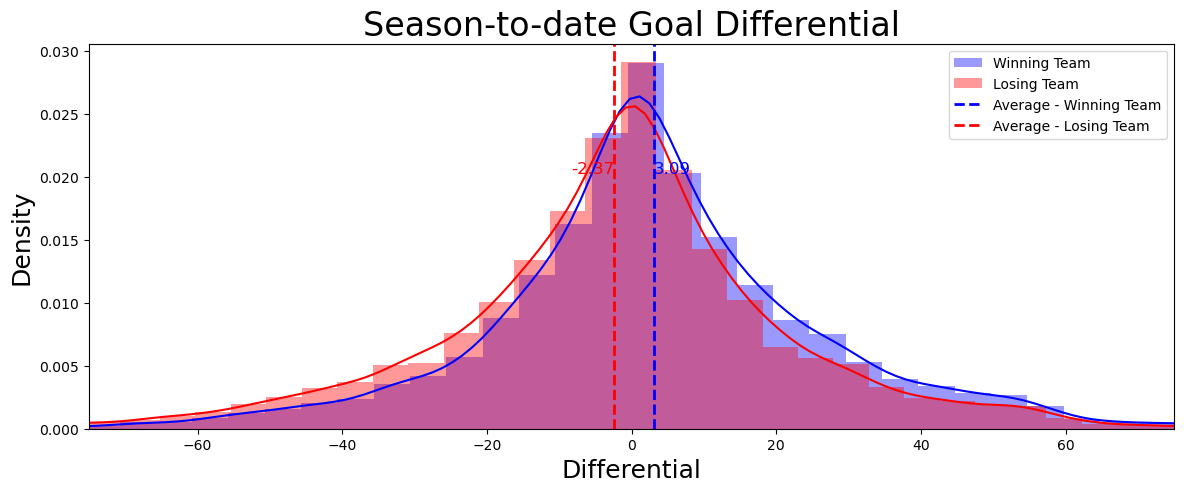

In [64]:
# Filter data for 'won' column equal to 1
won_team = new_df[new_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = new_df[new_df['won'] == 0]

plt.figure(figsize=(14, 5))

ax = sns.distplot(won_team['seasonGoalDiff'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['seasonGoalDiff'], color='red', label='Losing Team')

# Calculate and add vertical lines for the average values
average_won = won_team['seasonGoalDiff'].mean()
average_lost = lost_team['seasonGoalDiff'].mean()

ax.axvline(average_won, color='blue', linestyle='dashed', linewidth=2, label='Average - Winning Team')
ax.axvline(average_lost, color='red', linestyle='dashed', linewidth=2, label='Average - Losing Team')

# Add value labels to the lines
ax.text(average_won, 0.02, f'{average_won:.2f}', color='blue', fontsize=12, ha='left', va='bottom')
ax.text(average_lost, 0.02, f'{average_lost:.2f}', color='red', fontsize=12, ha='right', va='bottom')

ax.set_title('Season-to-date Goal Differential', fontsize=24)
ax.set_xlabel('Differential', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

# Set a specific range for the x-axis (exclude 0)
ax.set_xlim(left=-75, right=75)

plt.show()


In [29]:
new_df = pd.read_csv('new_testing_data2.csv')

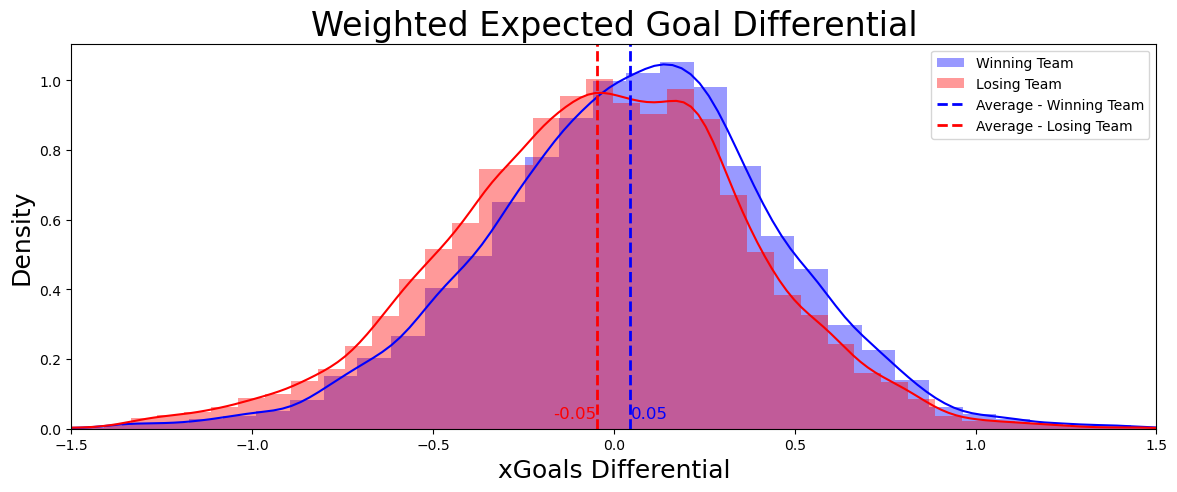

In [14]:
# Filter data for 'won' column equal to 1
won_team = new_df[new_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = new_df[new_df['won'] == 0]

plt.figure(figsize=(14, 5))

ax = sns.distplot(won_team['w_xGoalsDiff'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['w_xGoalsDiff'], color='red', label='Losing Team')

# Calculate and add vertical lines for the average values
average_won = won_team['w_xGoalsDiff'].mean()
average_lost = lost_team['w_xGoalsDiff'].mean()

ax.axvline(average_won, color='blue', linestyle='dashed', linewidth=2, label='Average - Winning Team')
ax.axvline(average_lost, color='red', linestyle='dashed', linewidth=2, label='Average - Losing Team')

# Add value labels to the lines
ax.text(average_won, 0.02, f'{average_won:.2f}', color='blue', fontsize=12, ha='left', va='bottom')
ax.text(average_lost, 0.02, f'{average_lost:.2f}', color='red', fontsize=12, ha='right', va='bottom')

ax.set_title('Weighted Expected Goal Differential', fontsize=24)
ax.set_xlabel('xGoals Differential', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

# Set a specific range for the x-axis (exclude 0)
ax.set_xlim(left=-1.5, right=1.5)

plt.show()


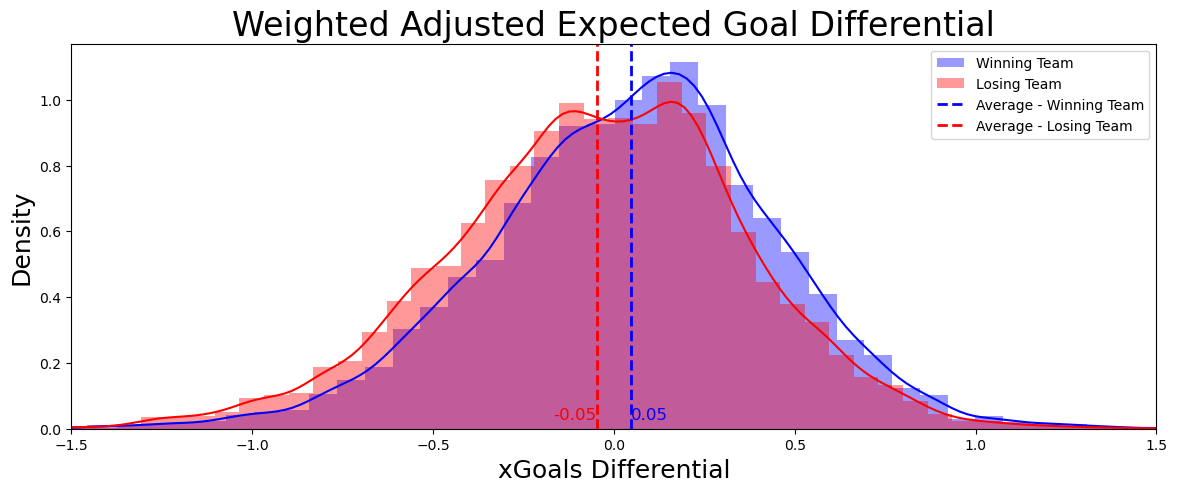

In [13]:
# Filter data for 'won' column equal to 1
won_team = new_df[new_df['won'] == 1]
# Filter data for 'won' column equal to 0
lost_team = new_df[new_df['won'] == 0]

plt.figure(figsize=(14, 5))

ax = sns.distplot(won_team['w_FSVAxGoalsDiff'], color='blue', label='Winning Team')
ax = sns.distplot(lost_team['w_FSVAxGoalsDiff'], color='red', label='Losing Team')

# Calculate and add vertical lines for the average values
average_won = won_team['w_FSVAxGoalsDiff'].mean()
average_lost = lost_team['w_FSVAxGoalsDiff'].mean()

ax.axvline(average_won, color='blue', linestyle='dashed', linewidth=2, label='Average - Winning Team')
ax.axvline(average_lost, color='red', linestyle='dashed', linewidth=2, label='Average - Losing Team')

# Add value labels to the lines
ax.text(average_won, 0.02, f'{average_won:.2f}', color='blue', fontsize=12, ha='left', va='bottom')
ax.text(average_lost, 0.02, f'{average_lost:.2f}', color='red', fontsize=12, ha='right', va='bottom')

ax.set_title('Weighted Adjusted Expected Goal Differential', fontsize=24)
ax.set_xlabel('xGoals Differential', fontsize=18)
ax.set_ylabel('Density', fontsize=18)
ax.legend(loc='upper right')

# Set a specific range for the x-axis (exclude 0)
ax.set_xlim(left=-1.5, right=1.5)

plt.show()


Interestingly, the data for expected goals for the losing team appears to have two peaks, one positive and one negative. This is likely due to the fact that the best teams have to play each other throughout the season. While we would expect losing teams to typically have a negative goal differential, when two good teams play each other, they likely have positive goal differentials. Only one can win, though, so in those cases a team with a positive goal differential lost the game.

Now that I'm comfortable that the new weighting methodology is useful for predicting outcomes, I can consider feature selection and begin to review individual variable performance. I will first take a look at the correlations between the variables and whether the team won or not.

In [6]:
correlations = new_df.corr()['won'].sort_values(ascending=False)[1:]
pd.options.display.float_format = '{:.6f}'.format

# Set the display option to show all rows
pd.set_option('display.max_rows', None)

correlations

w_FSVAxGoalsDiff    0.116590
w_AdjFenwick%       0.115863
w_SVAxGoalsDiff     0.114798
w_FAxGoalsDiff      0.113815
w_AdjCorsi%         0.113595
w_xGoalsDiff        0.111892
seasonGoalDiff      0.110082
w_Fenwick%          0.108309
w_goalDiff          0.107726
w_Shots%            0.106641
w_Corsi%            0.103393
home                0.091131
w_FSVAxGoals        0.084382
w_shots             0.083482
w_SVAxGoals         0.082471
last10diff          0.082212
w_FAxGoals          0.081009
w_win%              0.080748
w_xGoals            0.079145
w_HDSdiff           0.078975
w_goals             0.078907
seasonWin%          0.076879
last10wins          0.071203
GoalieSave%         0.065518
GoalieSAR           0.060356
last10goals         0.059231
w_PP%               0.050721
w_Shooting%         0.041920
w_PK%               0.041866
w_FO%               0.041731
w_Save%             0.039498
w_ShotEfficiency    0.024908
w_HDSRatio          0.019918
days                0.018622
w_TakeawayRati

The highest correlations using the rolling 10-game averages were all less than 0.1, so it is encouraging to see several of these new variables with higher correlations. I initially created some variables that looked at the same statistics in slightly different ways. For example, `w_AdjFenwick%` calculates the share of that variable that the team had over the calculation, while `wAdjFenwickDiff` calculates the difference between the variable accrued by the team and their opponents over the calculation. Since they are both using the same underlying data in the calculation and measuring essentially the same thing, we can drop the variable that has the lower correlation.

In [229]:
# List of columns to drop
columns_to_drop = [
    'wAdjFenwickDiff', 'w_FSVAxGoals%', 'w_SVAxGoals%', 'w_FAxGoals%', 'wAdjCorsiDiff',
    'w_xGoals%', 'w_FenwickDiff', 'w_ShotsDiff', 'w_goals%', 'w_CorsiDiff', 'w_HDS%',
    'last10win%', 'last10goal%', 'w_Fodiff', 'w_takeawaysDiff', 'w_giveawaysDiff',
    'w_hitsDiff', 'w_dZgiveaways%', 'w_dZgiveawaysDiff', 'w_blocksDiff'
]

# Drop specified columns from new_df
new_df.drop(columns=columns_to_drop, inplace=True)


In [53]:
# Set the display option to show all rows
pd.set_option('display.max_rows', 10)

new_df

,team_x,season,gameId,opposingTeam,home,won,days,B2B,dist,daydist,...,w_TakeawayRatio,w_win%,seasonWin%,w_DefEfficiency,w_ShotEfficiency,w_Shooting%,w_Save%,w_PK%,w_PP%,w_blocks%
0,NYR,2008,2008020001,TBL,0.000000,1.000000,10.000000,0,0.000000,0.000000,...,0.531563,0.000000,0.000000,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226
1,NYR,2008,2008020003,TBL,1.000000,1.000000,1.000000,1,1620.130000,1620.130000,...,0.531563,1.000000,1.000000,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226
2,NYR,2008,2008020010,CHI,1.000000,1.000000,5.000000,0,0.000000,0.000000,...,0.531563,1.000000,1.000000,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226
3,NYR,2008,2008020019,PHI,0.000000,1.000000,1.000000,1,137.470000,137.470000,...,0.531563,1.000000,1.000000,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226
4,NYR,2008,2008020034,NJD,1.000000,1.000000,2.000000,0,137.470000,68.735000,...,0.531563,1.000000,1.000000,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35339,LAK,2020,2020020852,COL,1.000000,0.000000,2.000000,0,3938.910000,1969.455000,...,0.326373,0.426848,0.411765,1.043614,1.060030,0.087846,0.903324,0.833286,0.168237,0.522584
35340,LAK,2020,2020020867,COL,1.000000,0.000000,1.000000,1,3695.830000,3695.830000,...,0.325374,0.410740,0.403846,1.044315,1.066888,0.088514,0.904027,0.828610,0.165915,0.529766
35341,LAK,2020,2020020456,STL,1.000000,0.000000,2.000000,0,4171.690000,2085.845000,...,0.319803,0.395528,0.396226,1.052157,1.073604,0.089049,0.903883,0.821946,0.161374,0.527971
35342,LAK,2020,2020020688,COL,0.000000,0.000000,2.000000,0,2687.270000,1343.635000,...,0.316790,0.381145,0.388889,1.043994,1.060066,0.087235,0.903675,0.826788,0.156996,0.525976


Now that we have a good set of variables, we can run some initial baseline models to evaluate performance. 

In [34]:
# Extract the target variable (y)
y = new_df['won']

# Exclude specific columns from X
columns_to_exclude = ['won', 'team_x', 'opposingTeam', 'season', 'gameId', 'Odds']
X = new_df.drop(columns=columns_to_exclude)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test = scaler.transform(X_test)

# Define a list of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Create an empty dataframe to store the metrics
metrics_df = pd.DataFrame(columns=['Training Accuracy', 'Test Accuracy'])

# Iterate through the classifiers
for model_name, model in classifiers.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the training data
    y_train_pred = model.predict(X_train)

    # Make predictions on the test data
    y_test_pred = model.predict(X_test)

    # Calculate accuracy on the training data
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Calculate accuracy on the test data
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Add the metrics to the dataframe
    metrics_df.loc[model_name] = [train_accuracy, test_accuracy]

# Print the comparison table
print(metrics_df)

                     Training Accuracy  Test Accuracy
Logistic Regression           0.574742       0.566491
Decision Tree                 1.000000       0.560315
SVM                           0.633353       0.568857
Random Forest                 1.000000       0.586859
XGBoost                       0.834877       0.570828


These results are disappointing, as they do not outperform the test accuracy results of the 10-game rolling average variable dataset. However, it's not currently an apples-to-apples comparison. In the previous modeling I had created variables not only for the team but also for the opposing team. That is, for every game each team's likelihood of winning would be predicted based on not only their own performance over the past 10 games, but also on the performance of their opponent over the past 10 games. The model then predicted the likelihood of winning for *each* team, as there were two rows for each game, one for each team. This is inefficient and possibly contradictory, as the model is not forced to choose between the two teams.

Rather than creating new variables for the opposing team for each game, it makes sense to adjust the dataset to include only a single row per game. That way there is no confusion about what the model is predicting, as there would be only one possible outcome field for each game. To do this, I will create separate dataframes for the home team and the away team in each game, and merge them based on `gameId`

In [65]:
new_df.to_csv('new_testing_data3.csv', index=False)

In [230]:
# home team dataframe
home_df = new_df[new_df['home'] == 1].copy()

In [231]:
# Set the display option to show all rows
pd.set_option('display.max_rows', 10)

home_df

,team_x,season,gameId,opposingTeam,home,won,days,B2B,dist,daydist,...,w_Save%,w_PK%,w_PP%,w_blocks%,GoaliexGA,GoalieGA,GoalieShots,GoalieSAR,GoalieSave%,Odds
1,NYR,2008,2008020003,TBL,1.000000,1.000000,1.000000,1,1620.130000,1620.130000,...,0.911019,0.872865,0.143644,0.435226,2.689000,1.000000,21.000000,1.689000,0.952381,NaN
2,NYR,2008,2008020010,CHI,1.000000,1.000000,5.000000,0,0.000000,0.000000,...,0.911019,0.872865,0.143644,0.435226,1.507000,1.000000,19.666667,0.507000,0.949153,NaN
4,NYR,2008,2008020034,NJD,1.000000,1.000000,2.000000,0,137.470000,68.735000,...,0.911019,0.872865,0.143644,0.435226,3.020000,3.000000,28.000000,0.020000,0.892857,NaN
5,NYR,2008,2008020044,BUF,1.000000,0.000000,2.000000,0,0.000000,0.000000,...,0.911019,0.872865,0.143644,0.435226,2.662300,1.300000,26.300000,1.362300,0.950570,NaN
6,NYR,2008,2008020057,TOR,1.000000,1.000000,2.000000,0,0.000000,0.000000,...,0.911019,0.872865,0.143644,0.435226,2.737200,1.866667,23.866667,0.870533,0.921788,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35333,LAK,2020,2020020765,ANA,1.000000,1.000000,2.000000,0,3434.330000,1717.165000,...,0.900432,0.828592,0.168153,0.513271,3.191766,3.181538,33.344615,0.010228,0.904586,-148.000000
35334,LAK,2020,2020020780,ANA,1.000000,0.000000,2.000000,0,2464.450000,1232.225000,...,0.902080,0.831351,0.163366,0.513589,2.691590,2.900000,26.985714,-0.208410,0.892536,-156.000000
35339,LAK,2020,2020020852,COL,1.000000,0.000000,2.000000,0,3938.910000,1969.455000,...,0.903324,0.833286,0.168237,0.522584,2.969451,3.275862,32.364532,-0.306411,0.898782,205.000000
35340,LAK,2020,2020020867,COL,1.000000,0.000000,1.000000,1,3695.830000,3695.830000,...,0.904027,0.828610,0.165915,0.529766,2.959754,3.257471,32.673563,-0.297717,0.900303,205.000000


We have previously said that the home team wins ~54% of games, so we can use this information to confirm that this home dataframe is accurate.

In [232]:
home_df['won'].mean()

0.5434019918515165

Looks good. Now I will create the away team dataframe.

In [233]:
# away team dataframe
away_df = new_df[new_df['home'] == 0].copy()

# Append '_a' to all column names in the new dataframe
away_df.columns = [col + '_a' for col in away_df.columns]

In [212]:
away_df

,team_x_a,season_a,gameId_a,opposingTeam_a,home_a,won_a,days_a,B2B_a,dist_a,daydist_a,...,w_win%_a,seasonWin%_a,w_DefEfficiency_a,w_ShotEfficiency_a,w_Shooting%_a,w_Save%_a,w_PK%_a,w_PP%_a,w_blocks%_a,Odds_a
0,NYR,2008,2008020001,TBL,0.000000,1.000000,10.000000,0,0.000000,0.000000,...,0.000000,0.000000,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226,NaN
3,NYR,2008,2008020019,PHI,0.000000,1.000000,1.000000,1,137.470000,137.470000,...,1.000000,1.000000,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226,NaN
7,NYR,2008,2008020070,DET,0.000000,0.000000,1.000000,1,774.150000,774.150000,...,0.785714,0.857143,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226,NaN
9,NYR,2008,2008020101,CBJ,0.000000,1.000000,4.000000,0,768.200000,192.050000,...,0.488889,0.666667,0.983678,0.882643,0.074383,0.911019,0.872865,0.143644,0.435226,NaN
11,NYR,2008,2008020121,NYI,0.000000,1.000000,2.000000,0,22.860000,11.430000,...,0.651515,0.727273,0.793637,0.864876,0.072892,0.927371,0.885375,0.145511,0.410037,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35336,LAK,2020,2020020810,ANA,0.000000,0.000000,1.000000,1,4070.730000,4070.730000,...,0.395408,0.395833,0.995805,1.019506,0.084072,0.904088,0.846692,0.163585,0.508767,-130.000000
35337,LAK,2020,2020020822,ARI,0.000000,1.000000,2.000000,0,3479.100000,1739.550000,...,0.379592,0.387755,1.049283,1.030786,0.083934,0.900384,0.849045,0.161336,0.511393,140.000000
35338,LAK,2020,2020020836,ARI,0.000000,1.000000,2.000000,0,3456.710000,1728.355000,...,0.403922,0.400000,1.051383,1.040319,0.085027,0.902153,0.838445,0.170579,0.519569,116.000000
35342,LAK,2020,2020020688,COL,0.000000,0.000000,2.000000,0,2687.270000,1343.635000,...,0.381145,0.388889,1.043994,1.060066,0.087235,0.903675,0.826788,0.156996,0.525976,290.000000


The away team winning percentage should be 1 - (home team winning percentage). Let's confirm.

In [106]:
away_df['won_a'].mean()

0.4565980081484835

Looks good again. Now we can merge the dataframes into a single merged dataframe, appending the away team variables with `_a` so that we can distinguish them from the home team's.

In [234]:
# Join home_df and away_df
merged_df = home_df.merge(away_df, how='inner', left_on='gameId', right_on='gameId_a', suffixes=('', '_a'))

In [108]:
merged_df

,team_x,season,gameId,opposingTeam,home,won,days,B2B,dist,daydist,...,w_TakeawayRatio_a,w_win%_a,seasonWin%_a,w_DefEfficiency_a,w_ShotEfficiency_a,w_Shooting%_a,w_Save%_a,w_PK%_a,w_PP%_a,w_blocks%_a
0,NYR,2008,2008020003,TBL,1.000000,1.000000,1.000000,1,1620.130000,1620.130000,...,0.437357,0.000000,0.000000,1.236257,1.057400,0.094095,0.883961,0.725389,0.147818,0.479782
1,NYR,2008,2008020010,CHI,1.000000,1.000000,5.000000,0,0.000000,0.000000,...,0.483030,0.296797,0.000000,1.094350,0.902984,0.088196,0.884530,0.732704,0.201137,0.528453
2,NYR,2008,2008020034,NJD,1.000000,1.000000,2.000000,0,137.470000,68.735000,...,0.426290,1.000000,1.000000,0.999247,1.045566,0.109071,0.910157,0.834484,0.249655,0.453064
3,NYR,2008,2008020044,BUF,1.000000,0.000000,2.000000,0,0.000000,0.000000,...,0.429336,1.000000,1.000000,0.932553,0.948633,0.098907,0.897028,0.767278,0.245400,0.444559
4,NYR,2008,2008020057,TOR,1.000000,1.000000,2.000000,0,0.000000,0.000000,...,0.552814,0.166667,0.333333,0.919909,1.044814,0.108242,0.912037,0.769728,0.182551,0.541754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17667,LAK,2020,2020020765,ANA,1.000000,1.000000,2.000000,0,3434.330000,1717.165000,...,0.406886,0.284864,0.291667,1.149361,0.971290,0.083238,0.895793,0.800000,0.096413,0.485576
17668,LAK,2020,2020020780,ANA,1.000000,0.000000,2.000000,0,2464.450000,1232.225000,...,0.409500,0.273469,0.285714,1.152184,0.958605,0.081980,0.894036,0.805250,0.094679,0.485312
17669,LAK,2020,2020020852,COL,1.000000,0.000000,2.000000,0,3938.910000,1969.455000,...,0.481496,0.683258,0.666667,1.170165,1.080385,0.101931,0.899584,0.788431,0.216779,0.406126
17670,LAK,2020,2020020867,COL,1.000000,0.000000,1.000000,1,3695.830000,3695.830000,...,0.476211,0.695210,0.673077,1.174774,1.079800,0.101104,0.899152,0.790879,0.218132,0.402264


In [11]:
# List of columns to drop
columns_to_drop = ['home', 'team_x_a', 'season_a', 'gameId_a', 'opposingTeam_a', 'home_a', 'won_a']

# Drop the specified columns from merged_df
merged_df.drop(columns=columns_to_drop, inplace=True)

I can also consolidate the back-to-back game variable from both teams into a single variable.

In [5]:
merged_df['B2Bcalc'] = merged_df['B2B'] - merged_df['B2B_a']

In [6]:
merged_df.drop(columns=['B2B', 'B2B_a'], inplace=True)

With this new consolidated dataframe, we are now trying to predict the likelihood of the home team winning. That now becomes the baseline model that we are looking to improve upon. The accuracy of the baseline is the probability that the home team wins.

In [127]:
merged_df['won'].value_counts(normalize=True)

1.000000   0.543402
0.000000   0.456598
Name: won, dtype: float64

In [128]:
baseline_preds = np.ones(merged_df.shape[0])
accuracy_score(merged_df['won'],baseline_preds)

0.5434019918515165

The industry standard for evaluating performance of sports prediction models is not actually accuracy; instead, most are evaluated based on log loss, a measure of how close the prediction probabilities are to the actual value. The lower the value, the closer the predictions are to the actual value ([Source](https://www.dratings.com/explaining-log-loss/)). Here is an example of the performance of tracked NHL models, evaluated based on log loss:

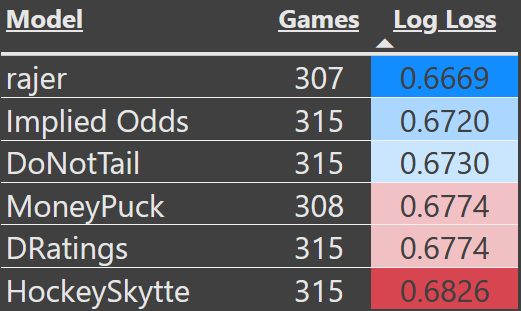

We can calculate the log loss for the baseline model:

In [129]:
baseline_probs = np.repeat(merged_df['won'].value_counts(normalize=True)[1], merged_df.shape[0])

log_loss(merged_df['won'], baseline_probs)

0.6893749691826798

Now that we have our new dataframe up and running, and preliminary modeling run, we can look at the full list of correlations of both teams relative to whether the home team won. 

In [235]:
correlations = merged_df.corr()['won'].sort_values(ascending=False)[1:]
pd.options.display.float_format = '{:.6f}'.format

# Set the display option to show all rows
pd.set_option('display.max_rows', None)

correlations

Odds_a                0.197445
w_AdjFenwick%         0.119893
w_FSVAxGoalsDiff      0.119235
w_FAxGoalsDiff        0.117061
w_SVAxGoalsDiff       0.116908
w_AdjCorsi%           0.115507
w_xGoalsDiff          0.114533
w_Fenwick%            0.113154
seasonGoalDiff        0.112416
w_Shots%              0.111932
w_goalDiff            0.109273
w_Corsi%              0.105933
last10diff            0.086722
w_HDSdiff             0.083091
w_win%                0.082560
w_shots               0.080943
seasonWin%            0.077590
w_FSVAxGoals          0.076284
last10wins            0.074290
w_SVAxGoals           0.074176
w_FAxGoals            0.073241
w_xGoals              0.071153
w_goals               0.066861
w_blocks%_a           0.064184
GoalieShots_a         0.057215
w_PK%                 0.053312
last10goals           0.051489
w_Save%               0.049963
w_FO%                 0.049339
w_dZoneGiveaway%_a    0.047525
GoaliexGA_a           0.046690
GoalieGA_a            0.044278
w_hits%_

It is worth noting that the highest correlations are based on the odds of each team winning. I had not considered including this as a feature in the model, because it feels like circular reasoning to base predictions on who is going to win a game on the implied prediction contained within the betting odds. However, it is information that is available prior to the games we are trying to predict, so it is potentially fair game. Unfortunately, I do not have the data for my entire dataset, but it is worth considering whether to add it in any model I maintain going forward.

While we are considering the odds, we can use them to calculate the implied probability that each team will win the game. This will be useful in evaluating model performance, particularly if we want to consider the ROI of betting on the model's predictions.

In [7]:
# Replace NaN values in 'Odds' with 0
merged_df['Odds'] = merged_df['Odds'].fillna(0)

In [8]:
# calculate implied probability of home team win
merged_df['Implied_prob'] = np.where(merged_df['Odds'] < 0, (merged_df['Odds']*-1)/((merged_df['Odds']*-1)+100) , 100/(merged_df['Odds']+100))

# calculate implied probability of away team win
merged_df['Implied_prob_a'] = np.where(merged_df['Odds_a'] < 0, (merged_df['Odds_a']*-1)/((merged_df['Odds_a']*-1)+100) , 100/(merged_df['Odds_a']+100))

In [ ]:
merged_df.to_csv('merged_testing_data4.csv', index=False)

In [2]:
merged_df = pd.read_csv('merged_testing_data4.csv')

Let's create a heatmap to review correlations among the variables. There are too many features to include in a single correlation matrix, so I will start with a subset.

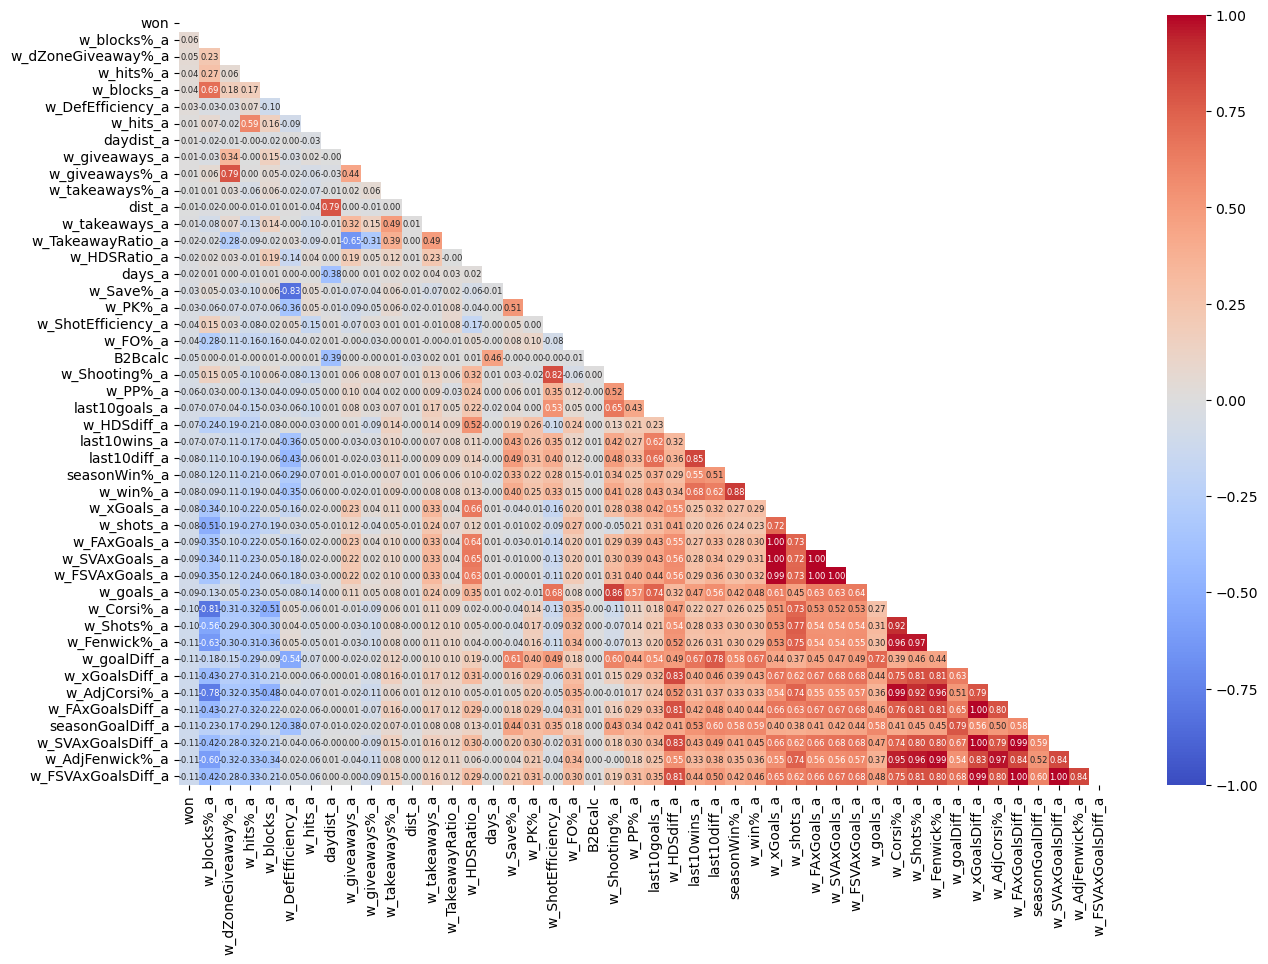

In [218]:
# Create a dataframe including a subset of variables
subset = merged_df[['won', 'w_AdjFenwick%', 'w_FSVAxGoalsDiff', 'w_AdjCorsi%', 'seasonGoalDiff', 'w_Shots%',
    'w_goalDiff', 'last10diff', 'w_HDSdiff', 'w_win%', 'seasonWin%', 'w_FSVAxGoals',
    'last10wins', 'w_goals', 'w_blocks%_a', 'w_PK%', 'last10goals', 'w_Save%', 'w_FO%',
    'w_dZoneGiveaway%_a', 'w_hits%_a', 'w_PP%', 'w_blocks_a', 'w_Shooting%', 'w_DefEfficiency_a',
    'w_ShotEfficiency', 'w_takeaways%', 'w_TakeawayRatio', 'w_HDSRatio', 'daydist_a',
    'w_giveaways_a', 'days', 'w_hits', 'w_takeaways_a', 'w_giveaways%', 'w_TakeawayRatio_a',
    'daydist', 'w_HDSRatio_a', 'w_Save%_a', 'w_PK%_a', 'w_blocks', 'w_ShotEfficiency_a',
    'w_FO%_a', 'w_DefEfficiency', 'B2Bcalc', 'w_dZoneGiveaway%', 'w_Shooting%_a', 'w_PP%_a',
    'w_blocks%', 'last10goals_a', 'w_HDSdiff_a', 'last10wins_a', 'last10diff_a', 'seasonWin%_a',
    'w_win%_a', 'w_shots_a', 'w_FSVAxGoals_a', 'w_goals_a', 'w_Shots%_a', 'w_goalDiff_a',
    'w_AdjCorsi%_a', 'seasonGoalDiff_a', 'w_AdjFenwick%_a', 'w_FSVAxGoalsDiff_a']]

# Calculate the correlation matrix for the selected columns
correlation_matrix_subset = subset.corr()

# Create a mask to hide the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_subset, dtype=bool))

# Set the font size
annot_font_size = 6

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(25, 10)) 
sns.heatmap(correlation_matrix_subset, center=0, vmin=-1, vmax=1, cmap='coolwarm', annot=True, fmt=".2f", mask=mask, annot_kws={"size": annot_font_size})
plt.show()

There remains collinearity, particularly between some of the shots data, as well as the expected goals data. This is to be expected, given that many of these variables are built from the same underlying metrics. Rather than pruning those variables now, I will hang on to them and make adjustments based on what the more detailed modeling is returning. Let's get to modeling!

## **Modeling**

Let's start by setting up the train test split and normalizing the data. 

In [3]:
# Define the features and the target
X = merged_df.drop(columns=['won', 'team_x', 
                           'season', 'gameId',
                           'opposingTeam', 'Odds_a',
                           'Implied_prob_a'
                           ])
y = merged_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
 
# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test_scaled = scaler.transform(X_test)

In [7]:
# Define the features and the target
X = merged_df.drop(columns=['won', 'team_x', 
                           'season', 'gameId',
                           'opposingTeam', 'Odds_a',
                           'Implied_prob_a'
                           ])
y = merged_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
 
# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test_scaled = scaler.transform(X_test)

I will start by running the same baseline modeling on the various classifiers with the new consolidated dataset.

In [27]:
# Define a list of classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=1),
    'SVM': SVC(random_state=1, probability=True),
    'Random Forest': RandomForestClassifier(random_state=1),
    'XGBoost': XGBClassifier(random_state=1)
}

# Create an empty dataframe to store the metrics
metrics_df = pd.DataFrame(columns=['Training Accuracy', 'Test Accuracy', 'Log Loss'])

# Iterate through the classifiers
for model_name, model in classifiers.items():
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the training data
    y_train_pred = model.predict(X_train)

    # Make predictions on the test data
    y_test_pred = model.predict(X_test)

    # Calculate accuracy on the training data
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Calculate accuracy on the test data
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Calculate log loss on the test data
    y_test_prob = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_test_prob)

    # Add the metrics to the dataframe
    metrics_df.loc[model_name] = [train_accuracy, test_accuracy, test_log_loss]

# Print the comparison table
print(metrics_df)

                     Training Accuracy  Test Accuracy   Log Loss
Logistic Regression           0.581736       0.597171   0.670978
Decision Tree                 1.000000       0.522207  17.221423
SVM                           0.667893       0.572843   0.678270
Random Forest                 1.000000       0.570014   0.683385
XGBoost                       0.917804       0.557850   0.729022


This is much more promising than what we saw before we created the merged_df dataset. Logistic regression in particular looks very good, with 59.7% accuracy and log loss of 0.671. The tree based classifiers show extreme overfitting, which is consistent with what we saw in previous modeling (and what we would expect). I will look to optimize hyperparameters for at least logistic regression, and likely some other models. Initially, though, I would like to follow up on the feature selection discussion above by running a Recursive Feature Elimination to understand which specific variables to consider keeping and dropping.

### Logistic Regression <a class="anchor" id="3a"></a>

In [46]:
# Instantiate the logistic regression model
model = LogisticRegression()

# Use Recursive Feature Elimination (RFE) to select features
selector = RFE(model, step=1)
selector = selector.fit(X_train_scaled, y_train)

# Get the selected features as a list
selected_features = X_train.columns[selector.support_].tolist()

# Train and evaluate the model with selected features
model.fit(X_train_scaled[:, selector.support_], y_train)
y_pred = model.predict(X_test_scaled[:, selector.support_])

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Selected Features: {accuracy:.6f}")

# Make predicted probabilities on the test data
y_pred_probs = model.predict_proba(X_test_scaled[:, selector.support_])

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_pred_probs)
print(f"Log Loss with Selected Features: {log_loss_value:.6f}")

# Print the selected features
print("Selected Features:", selected_features)

Test Accuracy with Selected Features: 0.588967
Log Loss with Selected Features: 0.669952
Selected Features: ['w_goals', 'w_xGoals', 'w_FSVAxGoals', 'w_shots', 'w_goalDiff', 'w_Shots%', 'w_Corsi%', 'w_Fenwick%', 'w_AdjCorsi%', 'w_AdjFenwick%', 'w_HDSdiff', 'w_xGoalsDiff', 'w_FAxGoalsDiff', 'w_SVAxGoalsDiff', 'w_FSVAxGoalsDiff', 'seasonGoalDiff', 'w_DefEfficiency', 'w_ShotEfficiency', 'w_Shooting%', 'w_Save%', 'Odds', 'w_goals_a', 'w_xGoals_a', 'w_FAxGoals_a', 'w_SVAxGoals_a', 'w_shots_a', 'w_takeaways_a', 'w_giveaways_a', 'w_goalDiff_a', 'w_giveaways%_a', 'w_Shots%_a', 'w_Corsi%_a', 'w_Fenwick%_a', 'w_AdjCorsi%_a', 'w_AdjFenwick%_a', 'w_xGoalsDiff_a', 'w_FAxGoalsDiff_a', 'w_SVAxGoalsDiff_a', 'w_FSVAxGoalsDiff_a', 'seasonGoalDiff_a', 'w_dZoneGiveaway%_a', 'w_TakeawayRatio_a', 'w_ShotEfficiency_a', 'w_Shooting%_a', 'w_Save%_a', 'GoalieGA_a', 'GoalieShots_a', 'GoalieSave%_a', 'B2Bcalc', 'Implied_prob']


This model underperformed the initial logistic regression model by almost 1% accuracy, but showed good improvement in log loss. This is the first time I have generated a log loss below 0.67 (if only slightly). The features maintained include a variety of types of variables, including expected goals, goal differential, save%, back-to-back games, winning percentage, and individual goalie data, so this gives me confidence that the categories of variables that I have created for this exercise are all contributing to the predictive power of the model.

Next I will try to optimize hyperparameters for logistic regression.

In [47]:
# Create a logistic regression model
model = LogisticRegression()

# Define hyperparameters for tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit the model on the training data with grid search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to create the final model
final_model = LogisticRegression(**best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred = final_model.predict(X_test_scaled)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

# Make predicted probabilities on the test data
y_test_probs = final_model.predict_proba(X_test_scaled)

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_test_probs)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", log_test_accuracy)
print("Log Loss:", log_loss_value)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.5923620933521924
Log Loss: 0.6690690983992285


This grid search resulted in a slight improvement in log loss, but again did not exceed the accuracy of the baseline. I may not be able to do better than 59.7% with the variables that I have! We could potential try combining hyperparamater optimization with Recursive Feature Elimination to see if that improves the results.

In [50]:
# Instantiate the logistic regression model
model = LogisticRegression()

# Use Recursive Feature Elimination (RFE) to select features
selector = RFE(model, step=1)
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[selector.support_]

# Define hyperparameters for tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=1)

# Fit the model on the training data with grid search
grid_search.fit(X_train[selected_features], y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Use the best parameters to create the final model
final_model = LogisticRegression(**best_params)

# Fit the final model on the training data
final_model.fit(X_train[selected_features], y_train)

# Make predictions on the test data
y_pred = final_model.predict(X_test[selected_features])

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy with Selected Features: {accuracy:.6f}")

# Make predicted probabilities on the test data
y_pred_probs = final_model.predict_proba(X_test[selected_features])

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_pred_probs)
print(f"Log Loss with Selected Features: {log_loss_value:.6f}")

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Test Accuracy with Selected Features: 0.585856
Log Loss with Selected Features: 0.671601
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


No luck. Given that I still have all the variables in there, I will also try PCA.

In [57]:
# Create a PCA instance
pca = PCA()

# Create a logistic regression model
model = LogisticRegression()

# Define hyperparameters for tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Create a pipeline with PCA and Logistic Regression
pipeline = Pipeline([
    ('pca', pca),
    ('model', grid_search)
])

# Fit the pipeline on the training data
pipeline.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = pipeline.named_steps['model'].best_params_

# Use the best parameters to create the final model
final_model = LogisticRegression(**best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred = final_model.predict(X_test_scaled)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

# Make predicted probabilities on the test data
y_test_probs = final_model.predict_proba(X_test_scaled)

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_test_probs)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", log_test_accuracy)
print("Log Loss:", log_loss_value)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.585007072135785
Log Loss: 0.6699008418413381


No improvement to accuracy, although a good log loss slightly below 0.67. As a last resort, I will try some manual feature selection to see if I can get accuracy above 60%.

In [244]:
# Define the features and the target
X = merged_df[['w_AdjFenwick%', 'B2Bcalc', 'w_Fenwick%_a', 'last10wins', 'last10wins_a', 'w_goals', 'w_takeaways', 'w_goalDiff', 'w_goals_a', 'w_goalDiff_a', 
              'w_hits_a', 'w_FAxGoals_a', 'w_blocks%_a', 'w_Save%', 'w_Save%_a', 'w_ShotEfficiency', 'w_DefEfficiency', 'seasonWin%', 'w_win%',
              'w_PP%_a', 'w_PK%', 'w_PK%_a', 'w_xGoalsDiff_a', 'w_hits%_a', 'w_FO%_a', 'w_giveaways%_a', 'w_HDSdiff', 'w_HDSRatio']]
y = merged_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
 
# Fit the scaler to the training data and transform
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
log_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

# Make predicted probabilities on the test data
y_test_probs = model.predict_proba(X_test)

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_test_probs)

print("Training Accuracy:", log_train_accuracy)
print("Test Accuracy:", log_test_accuracy)
print("Log Loss:", log_loss_value)

Training Accuracy: 0.5817358704109783
Test Accuracy: 0.5971711456859972
Log Loss: 0.670978381978538


It looks like 59.7% accuracy is pretty much the upper limit, at least with logistic regresssion.

### SVM <a class="anchor" id="3b"></a>

Next we will try hyperparameter optimization on a support vector machine.

In [276]:
# Build the SVM model
model = SVC(probability=True, random_state=1)

# Define the hyperparameter grid for tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_log_loss',  # Note: SVC does not have predict_proba, so log_loss is not directly supported
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final model
final_model = SVC(probability=True, random_state=1, **best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred_probs = final_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate accuracy on the test data
svm_test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate log loss on the test data (note: using predict_proba from the final model)
svm_log_loss_value = log_loss(y_test, y_test_pred_probs)

print("Best Hyperparameters:", best_params)
print("SVM Test Accuracy:", svm_test_accuracy)
print("SVM Log Loss:", svm_log_loss_value)



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
SVM Test Accuracy: 0.592079207920792
SVM Log Loss: 0.6702121127225912


### Random Forest <a class="anchor" id="3c"></a>

Next we will try hyperparameter optimizataion on a Random Forest classifier.

In [277]:
# Build the Random Forest model
model = RandomForestClassifier(random_state=1)

# Define the hyperparameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_log_loss',  # Note: RandomForestClassifier has predict_proba, so log_loss is supported
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final model
final_model = RandomForestClassifier(random_state=1, **best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred_probs = final_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate accuracy on the test data
rf_test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate log loss on the test data
rf_log_loss_value = log_loss(y_test, y_test_pred_probs)

print("Best Hyperparameters:", best_params)
print("Random Forest Test Accuracy:", rf_test_accuracy)
print("Random Forest Log Loss:", rf_log_loss_value)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Test Accuracy: 0.5867043847241867
Random Forest Log Loss: 0.6717528102417436


### XGBoost <a class="anchor" id="3c"></a>

Next we will try hyperparameter optimizataion on a XGBoost classifier.

In [63]:
# Build the XGBoost model
model = XGBClassifier(objective='binary:logistic', random_state=1)

# Define the hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Define log loss as the scoring metric for hyperparameter tuning
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=log_loss_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model with hyperparameter tuning on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final model
final_model = XGBClassifier(objective='binary:logistic', random_state=1, **best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred_probs = final_model.predict_proba(X_test_scaled)[:, 1]
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate accuracy on the test data
xgb_test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate log loss on the test data
xgb_log_loss_value = log_loss(y_test, y_test_pred_probs)

print("Best Hyperparameters:", best_params)
print("XGBoost Test Accuracy:", xgb_test_accuracy)
print("XGBoost Log Loss:", xgb_log_loss_value)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost Test Accuracy: 0.5852899575671853
XGBoost Log Loss: 0.6714092771085866


### Neural Network <a class="anchor" id="3e"></a>

Finally, we will try a neural network.

In [28]:
# Build the neural network model
def create_model(optimizer='adam', dropout_rate=0.5, neurons=24, activation='relu'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for tuning
param_grid = {
    'optimizer': ['adam', 'sgd', 'RMSprop'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'activation': ['relu', 'sigmoid', 'linear'],
    'neurons': [12, 24, 36]
}

# Create the neural network model
neural_network = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, batch_size=64, verbose=0)

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=neural_network,
    param_grid=param_grid,
    scoring={'accuracy': make_scorer(accuracy_score), 'log_loss': make_scorer(log_loss, greater_is_better=False)},
    cv=3,
    refit='log_loss',
    verbose=1
)

# Train the model with hyperparameter tuning on the training data
grid_search.fit(X_train_scaled, y_train, validation_split=0.2)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create the final model
final_model = create_model(**best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, verbose=0)

# Evaluate the final model on the test data
y_test_pred_probs = final_model.predict(X_test_scaled)
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

# Calculate accuracy on the test data
nn_test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate log loss on the test data
nn_log_loss_value = log_loss(y_test, y_test_pred_probs) 

print("Best Hyperparameters:", best_params)
print("Neural Network Test Accuracy:", nn_test_accuracy)
print("Neural Network Log Loss:", nn_log_loss_value)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
111/111 [==============================] - 0s 3ms/step
Best Hyperparameters: {'activation': 'sigmoid', 'dropout_rate': 0.7, 'neurons': 12, 'optimizer': 'RMSprop'}
Neural Network Test Accuracy: 0.5903818953323904
Neural Network Log Loss: 0.6711232958098748


In [246]:
# Regression with the RFE variables
# PCA added
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Define the features and the target
X = merged_df[['days', 'w_goals', 'w_goalDiff', 'w_takeaways%', 'w_giveaways%',
       'w_Shots%', 'w_Corsi%', 'w_FO%', 'w_Fenwick%', 'w_AdjCorsi%',
       'w_AdjFenwick%', 'w_HDSdiff', 'w_xGoalsDiff', 'w_FAxGoalsDiff',
       'w_SVAxGoalsDiff', 'w_FSVAxGoalsDiff', 'w_dZoneGiveaway%',
       'w_TakeawayRatio', 'w_win%', 'seasonWin%', 'w_Save%', 'w_PK%',
       'w_goals_a', 'w_FSVAxGoals_a', 'w_goalDiff_a', 'w_takeaways%_a',
       'w_giveaways%_a', 'w_Corsi%_a', 'w_Fenwick%_a', 'w_AdjCorsi%_a',
       'w_AdjFenwick%_a', 'w_HDSdiff_a', 'w_xGoalsDiff_a', 'w_FAxGoalsDiff_a',
       'w_SVAxGoalsDiff_a', 'w_dZoneGiveaway%_a', 'w_win%_a', 'seasonWin%_a',
       'w_DefEfficiency_a', 'w_Save%_a', 'w_PK%_a', 'w_PP%_a', 'w_blocks%_a',
       'B2Bcalc']]
y = merged_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test_scaled = scaler.transform(X_test)

# Create a PCA instance
pca = PCA()

# Create a logistic regression model
model = LogisticRegression()

# Define hyperparameters for tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Create a pipeline with PCA and Logistic Regression
pipeline = Pipeline([
    ('pca', pca),
    ('model', grid_search)
])

# Fit the pipeline on the training data
pipeline.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = pipeline.named_steps['model'].best_params_

# Use the best parameters to create the final model
final_model = LogisticRegression(**best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred = final_model.predict(X_test_scaled)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

# Make predicted probabilities on the test data
y_test_probs = final_model.predict_proba(X_test_scaled)

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_test_probs)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", log_test_accuracy)
print("Log Loss:", log_loss_value)

Best Hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy: 0.5903818953323904
Log Loss: 0.670236529851802


In [68]:
# Basic regression playing
# testing
from sklearn.metrics import log_loss

# Define the features and the target
# X = model_df
X = merged_df[['w_AdjFenwick%', 'B2Bcalc', 'w_Fenwick%_a', 'last10wins', 'last10wins_a', 'w_goals', 'w_takeaways', 'w_goalDiff', 'w_goals_a', 'w_goalDiff_a', 
              'w_hits_a', 'w_FAxGoals_a', 'w_blocks%_a', 'w_Save%', 'w_Save%_a', 'w_ShotEfficiency', 'w_DefEfficiency', 'seasonWin%', 'w_win%',
              'w_PP%_a', 'w_PK%', 'w_PK%_a', 'w_xGoalsDiff_a', 'w_hits%_a', 'w_FO%_a', 'w_giveaways%_a', 'w_HDSdiff', 'w_HDSRatio', 'GoalieSAR_a', 
              'GoaliexGA']]
y = merged_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
 
# Fit the scaler to the training data and transform
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
log_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

# Make predicted probabilities on the test data
y_test_probs = model.predict_proba(X_test)

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_test_probs)

print("Training Accuracy:", log_train_accuracy)
print("Test Accuracy:", log_test_accuracy)
print("Log Loss:", log_loss_value)

Training Accuracy: 0.5816651340454128
Test Accuracy: 0.5903818953323904
Log Loss: 0.6709214478204027


In [239]:
# Regression with the RFE variables
# PCA added
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Define the features and the target
X = merged_df[['w_AdjFenwick%', 'B2Bcalc', 'w_Fenwick%_a', 'last10wins', 'last10wins_a', 'w_goals', 'w_takeaways', 'w_goalDiff', 'w_goals_a', 'w_goalDiff_a', 
              'w_hits_a', 'w_FAxGoals_a', 'w_blocks%_a', 'w_Save%', 'w_Save%_a', 'w_ShotEfficiency', 'w_DefEfficiency', 'seasonWin%', 'w_win%',
              'w_PP%_a', 'w_PK%', 'w_PK%_a', 'w_xGoalsDiff_a', 'w_hits%_a', 'w_FO%_a', 'w_giveaways%_a', 'w_HDSdiff', 'w_HDSRatio']]
y = merged_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()

# Fit the scaler to the training data and transform
X_train_scaled = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression()

# Define hyperparameters for tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['liblinear', 'lbfgs']
}

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Create a pipeline with PCA and Logistic Regression
pipeline = Pipeline([
   ('model', grid_search)
])

# Fit the pipeline on the training data
pipeline.fit(X_train_scaled, y_train)

# Get the best parameters from the grid search
best_params = pipeline.named_steps['model'].best_params_

# Use the best parameters to create the final model
final_model = LogisticRegression(**best_params)

# Fit the final model on the training data
final_model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_test_pred = final_model.predict(X_test_scaled)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

# Make predicted probabilities on the test data
y_test_probs = final_model.predict_proba(X_test_scaled)

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_test_probs)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", log_test_accuracy)
print("Log Loss:", log_loss_value)

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Test Accuracy: 0.5881188118811881
Log Loss: 0.6716184731426266


In [102]:
# Define the features and the target
X = merged_df[['days', 'w_goals', 'w_blocks', 'w_goalDiff', 'w_takeaways%',
       'w_giveaways%', 'w_Shots%', 'w_Corsi%', 'w_FO%', 'w_Fenwick%',
       'w_AdjCorsi%', 'w_AdjFenwick%', 'w_HDSdiff', 'w_FAxGoalsDiff',
       'w_SVAxGoalsDiff', 'w_FSVAxGoalsDiff', 'w_dZoneGiveaway%',
       'w_TakeawayRatio', 'w_win%', 'seasonWin%', 'w_Save%', 'w_PK%', 'w_PP%',
       'w_goals_a', 'w_FAxGoals_a', 'w_FSVAxGoals_a', 'w_takeaways_a',
       'w_goalDiff_a', 'w_takeaways%_a', 'w_Corsi%_a', 'w_Fenwick%_a',
       'w_AdjCorsi%_a', 'w_AdjFenwick%_a', 'w_HDSdiff_a', 'w_xGoalsDiff_a',
       'w_FAxGoalsDiff_a', 'w_SVAxGoalsDiff_a', 'w_FSVAxGoalsDiff_a',
       'w_dZoneGiveaway%_a', 'w_win%_a', 'w_Save%_a', 'w_PK%_a', 'w_PP%_a',
       'w_blocks%_a', 'B2Bcalc']]
y = merged_df['won']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a scaler, then apply it to the features
scaler = StandardScaler()
 
# Fit the scaler to the training data and transform
X_train = scaler.fit_transform(X_train)

# Apply the scaler to the test data
X_test = scaler.transform(X_test)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = model.predict(X_train)

# Make predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate accuracy on the training data
log_train_accuracy = accuracy_score(y_train, y_train_pred)

# Calculate accuracy on the test data
log_test_accuracy = accuracy_score(y_test, y_test_pred)

# Make predicted probabilities on the test data
y_test_probs = model.predict_proba(X_test)

# Calculate log loss on the test data
log_loss_value = log_loss(y_test, y_test_probs)

print("Training Accuracy:", log_train_accuracy)
print("Test Accuracy:", log_test_accuracy)
print("Log Loss:", log_loss_value)

Training Accuracy: 0.5842116432057721
Test Accuracy: 0.5875530410183876
Log Loss: 0.6710064406948324


## **Modeling Performance**

As stated above, I evaluated the models' peformance on accuracy and log loss. The table below displays the best-performing model for each classifier.

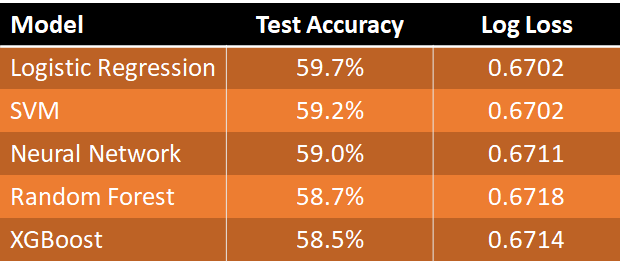

Model performance was very consistent across the different classifiers. This suggests that we are pretty much at the upper limit of accuracy with the variables that we have.

An additional, perhaps more accurate means to evaluate model performance is the return on investment one would receive by betting on the predctions that it generated. I already introduced the moneyline concept above, and we can use that to calculate the ROI for the best-performing model (logistic regression). We can use our test data to perform the calculations. I'll start by creating a dataframe that has all of the elements necessary to calculate ROI, including the odds/moneyline and implied probabilities of each team winning. I will also add the predicted probabilities from the model. 

In [75]:
# Extract the relevant columns from merged_df for evaluation
evaluation_df = merged_df[['gameId', 'team_x', 'opposingTeam', 'won', 'Odds', 'Odds_a', 'Implied_prob', 'Implied_prob_a']].copy()

# Convert X_test to a DataFrame with the same columns as X
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Make predicted probabilities on the test data
y_pred_probs = model.predict_proba(X_test_df)

# Add the predicted probabilities to the evaluation_df based on indices
evaluation_df.loc[X_test_df.index, 'Predicted_Probability'] = y_pred_probs[:, 1]

# Display the evaluation DataFrame
print(evaluation_df)


           gameId team_x opposingTeam  won   Odds  Odds_a  Implied_prob  \
0      2008020003    NYR          TBL  1.0    0.0     NaN      1.000000   
1      2008020010    NYR          CHI  1.0    0.0     NaN      1.000000   
2      2008020034    NYR          NJD  1.0    0.0     NaN      1.000000   
3      2008020044    NYR          BUF  0.0    0.0     NaN      1.000000   
4      2008020057    NYR          TOR  1.0    0.0     NaN      1.000000   
...           ...    ...          ...  ...    ...     ...           ...   
17667  2020020765    LAK          ANA  1.0 -148.0   134.0      0.596774   
17668  2020020780    LAK          ANA  0.0 -156.0   141.0      0.609375   
17669  2020020852    LAK          COL  0.0  205.0  -230.0      0.327869   
17670  2020020867    LAK          COL  0.0  205.0  -230.0      0.327869   
17671  2020020456    LAK          STL  0.0  107.0  -117.0      0.483092   

       Implied_prob_a  Predicted_Probability  
0                 NaN               0.522870  
1    

In [271]:
evaluation_df.isna().sum()

gameId                       0
team_x                       0
opposingTeam                 0
won                          0
Odds                         0
Odds_a                    6228
Implied_prob                 0
Implied_prob_a            6228
Predicted_Probability    14137
dtype: int64

The null values are expected, for two reasons. First, my odds dataset only included 2/3 of the games in my full dataset; second, we are only generating predicting probabilities for the rows that were in the test dataset. I can therefore drop the rows with null values. This leaves a test set of 2,280 games on which to test betting strategies.

In [76]:
# Drop rows with NaN values
evaluation_df = evaluation_df.dropna()

# Display the updated DataFrame
evaluation_df

,gameId,team_x,opposingTeam,won,Odds,Odds_a,Implied_prob,Implied_prob_a,Predicted_Probability
164,2012020015,NYR,PIT,0.0,-110.0,-110.0,0.523810,0.523810,0.461412
165,2012020037,NYR,BOS,1.0,-130.0,110.0,0.565217,0.476190,0.642619
166,2012020058,NYR,TOR,1.0,-180.0,160.0,0.642857,0.384615,0.439472
167,2012020080,NYR,PHI,1.0,-170.0,150.0,0.629630,0.400000,0.583401
168,2012020095,NYR,PIT,0.0,-120.0,100.0,0.545455,0.500000,0.479173
...,...,...,...,...,...,...,...,...,...
3388,2021021204,DAL,SJS,1.0,-223.0,203.0,0.690402,0.330033,0.339002
3389,2021021255,DAL,SEA,1.0,-310.0,270.0,0.756098,0.270270,0.631965
3390,2021021281,DAL,VGK,1.0,-105.0,-105.0,0.512195,0.512195,0.637875
3391,2021021287,DAL,ARI,0.0,-470.0,385.0,0.824561,0.206186,0.367899


My first betting strategy is to bet $100 on the team the model believes has the higher likelihood of winning each game. While this intuitively makes sense, it is something of a "dumb" strategy, because it does not take into account the odds, and how they relate to my predicted probabilities.  

To determine profitability, per bet profits are calculated based on the historical moneyline for each game, and combined into an overall profit.

In [25]:
# Create a new column 'profit' with default value 0
evaluation_df['profit'] = 0

# Condition for team_x winning the bet
team_x_win_condition = (evaluation_df['Predicted_Probability'] > 0.5) & (evaluation_df['won'] == 1)

# Condition for opposingTeam winning the bet
opp_team_win_condition = (evaluation_df['Predicted_Probability'] < 0.5) & (evaluation_df['won'] == 0)

# Calculate profit for team_x winning the bet
evaluation_df.loc[team_x_win_condition, 'profit'] = evaluation_df.loc[team_x_win_condition, 'Odds'].where(
    evaluation_df['Odds'] > 0,
    (100 / evaluation_df['Odds'].abs()) * 100
)

# Calculate profit for opposingTeam winning the bet
evaluation_df.loc[opp_team_win_condition, 'profit'] = evaluation_df.loc[opp_team_win_condition, 'Odds_a'].where(
    evaluation_df['Odds_a'] > 0,
    (100 / evaluation_df['Odds_a'].abs()) * 100
)

# Loss for team_x losing the bet
evaluation_df.loc[(evaluation_df['Predicted_Probability'] > 0.5) & (evaluation_df['won'] == 0), 'profit'] = -100

# Loss for opposingTeam losing the bet
evaluation_df.loc[(evaluation_df['Predicted_Probability'] < 0.5) & (evaluation_df['won'] == 1), 'profit'] = -100

# Display the updated DataFrame
evaluation_df


,gameId,team_x,opposingTeam,won,Odds,Odds_a,Implied_prob,Implied_prob_a,Predicted_Probability,profit
168,2012020095,NYR,PIT,0.0,-120.0,100.0,0.545455,0.454545,0.443945,100.000000
177,2012020329,NYR,PHI,1.0,-135.0,115.0,0.574468,0.425532,0.550006,74.074074
183,2012020538,NYR,PIT,1.0,-120.0,100.0,0.545455,0.454545,0.530043,83.333333
185,2012020645,NYR,FLA,1.0,-290.0,230.0,0.743590,0.256410,0.646590,34.482759
191,2013020215,NYR,ANA,0.0,-126.0,106.0,0.557522,0.442478,0.511958,-100.000000
...,...,...,...,...,...,...,...,...,...,...
17652,2020020742,LAK,ARI,0.0,-101.0,-109.0,0.502488,0.497512,0.588488,-100.000000
17656,2020020481,LAK,VGK,0.0,135.0,-150.0,0.425532,0.574468,0.412221,66.666667
17663,2020020674,LAK,VGK,0.0,182.0,-202.0,0.354610,0.645390,0.380327,49.504950
17665,2020020240,LAK,MIN,0.0,145.0,-160.0,0.408163,0.591837,0.474079,62.500000


In [78]:
#calculate cumulative profit
evaluation_df['Profit_cumsum'] = evaluation_df['profit'].cumsum()

In [255]:
evaluation_df

,gameId,team_x,opposingTeam,won,Odds,Odds_a,Implied_prob,Implied_prob_a,Predicted_Probability,profit,Profit_cumsum
0,2012020095,NYR,PIT,0.0,-120.0,100.0,0.545455,0.454545,0.443945,100.000000,100.000000
1,2012020329,NYR,PHI,1.0,-135.0,115.0,0.574468,0.425532,0.550006,74.074074,174.074074
2,2012020538,NYR,PIT,1.0,-120.0,100.0,0.545455,0.454545,0.530043,83.333333,257.407407
3,2012020645,NYR,FLA,1.0,-290.0,230.0,0.743590,0.256410,0.646590,34.482759,291.890166
4,2013020215,NYR,ANA,0.0,-126.0,106.0,0.557522,0.442478,0.511958,-100.000000,191.890166
...,...,...,...,...,...,...,...,...,...,...,...
2276,2020020742,LAK,ARI,0.0,-101.0,-109.0,0.502488,0.497512,0.588488,-100.000000,2214.754331
2277,2020020481,LAK,VGK,0.0,135.0,-150.0,0.425532,0.574468,0.412221,66.666667,2281.420998
2278,2020020674,LAK,VGK,0.0,182.0,-202.0,0.354610,0.645390,0.380327,49.504950,2330.925948
2279,2020020240,LAK,MIN,0.0,145.0,-160.0,0.408163,0.591837,0.474079,62.500000,2393.425948


This strategy turned out to be profitable, returning \\$2,461. Of course, I had to bet \\$100 per game to make that profit, meaning a total investment of $228,000, for an ROI of ~1.1%. The graph below shows the cumulative profit over the course of the 2,280 games.

In [80]:
evaluation_df.reset_index(drop=True, inplace=True)

In [81]:
evaluation_df.to_csv('evaluation_data.csv', index=False)

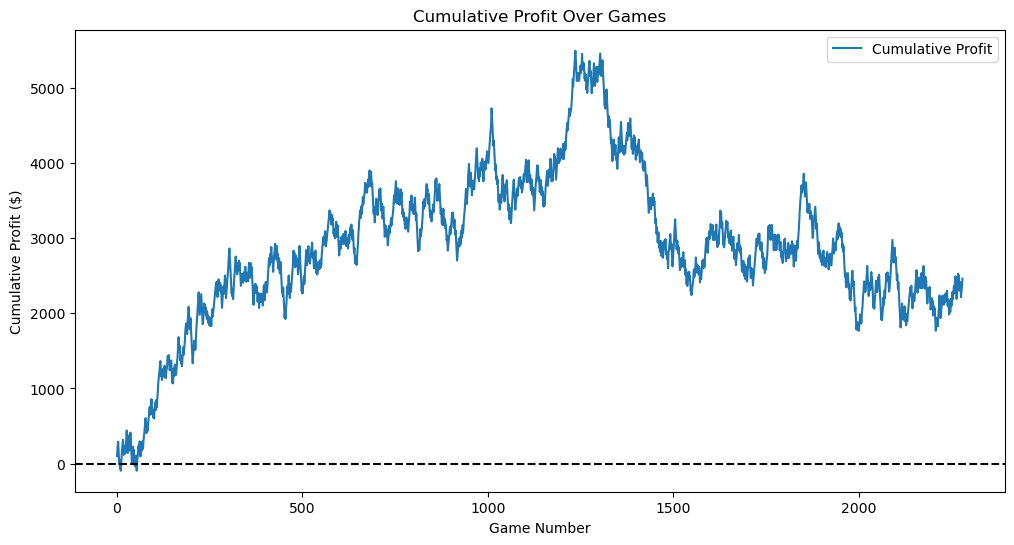

In [38]:
import matplotlib.pyplot as plt

# Assuming 'Profit_cumsum' is already calculated in the DataFrame

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative profit against the game number
ax.plot(evaluation_df['Profit_cumsum'], label='Cumulative Profit')

# Set labels and title
ax.set_xlabel('Game Number')
ax.set_ylabel('Cumulative Profit ($)')
ax.set_title('Cumulative Profit Over Games')
ax.axhline(0, linestyle = 'dashed', color = 'black')

# Add a legend
ax.legend()

# Show the plot
plt.show()



If the above betting strategy is "dumb", surely I can come up with a smarter one. Since my model generates a specific probability of each team winning the game, rather than simply a binary favorite/underdog, I should be able to use that to refine the betting strategy. If instead of betting on the team the model believes will win, I can compare the model's predicted probabilities to the moneyling implied probabilities, and bet on the team where the predicted probability exceeds the implied probability. This strategy leverages the fact that payouts are based on the implied probabilities, so if the model believes a team has a higher probability than the implied, betting on that team should result in a higher expected value. In some cases, this strategy would mean not betting on either team, as the commission/profit built into the moneyline could push both teams' implied probabilities higher than the model's predicted probabilities.

Again, I will simulate betting $100 per game that I bet on, and calculate the total profit.

In [273]:
# Create a new column 'Profit2' with default value 0
evaluation_df['Profit2'] = 0

# Condition for team_x winning the bet based on the new criteria
team_x_win_condition = (evaluation_df['Predicted_Probability'] > evaluation_df['Implied_prob']) & (evaluation_df['won'] == 1)

# Condition for opposingTeam winning the bet based on the new criteria
opp_team_win_condition = ((1 - evaluation_df['Predicted_Probability']) > evaluation_df['Implied_prob_a']) & (evaluation_df['won'] == 0)

# Calculate profit for team_x winning the bet
evaluation_df.loc[team_x_win_condition, 'Profit2'] = evaluation_df.loc[team_x_win_condition, 'Odds'].where(
    evaluation_df['Odds'] > 0,
    (100 / evaluation_df['Odds'].abs()) * 100
)

# Calculate profit for opposingTeam winning the bet
evaluation_df.loc[opp_team_win_condition, 'Profit2'] = evaluation_df.loc[opp_team_win_condition, 'Odds_a'].where(
    evaluation_df['Odds_a'] > 0,
    (100 / evaluation_df['Odds_a'].abs()) * 100
)

# Loss for team_x losing the bet
loss_condition_team_x = (evaluation_df['Predicted_Probability'] > evaluation_df['Implied_prob']) & (evaluation_df['won'] == 0)
evaluation_df.loc[loss_condition_team_x, 'Profit2'] = -100

# Loss for opposingTeam losing the bet
loss_condition_opp_team = ((1 - evaluation_df['Predicted_Probability']) > evaluation_df['Implied_prob_a']) & (evaluation_df['won'] == 1)
evaluation_df.loc[loss_condition_opp_team, 'Profit2'] = -100

# Display the updated DataFrame
print(evaluation_df[['gameId', 'team_x', 'opposingTeam', 'won', 'Odds', 'Odds_a', 'Implied_prob', 'Implied_prob_a', 'Predicted_Probability', 'Profit2']])


           gameId team_x opposingTeam  won   Odds  Odds_a  Implied_prob  \
168    2012020095    NYR          PIT  0.0 -120.0   100.0      0.545455   
177    2012020329    NYR          PHI  1.0 -135.0   115.0      0.574468   
183    2012020538    NYR          PIT  1.0 -120.0   100.0      0.545455   
185    2012020645    NYR          FLA  1.0 -290.0   230.0      0.743590   
191    2013020215    NYR          ANA  0.0 -126.0   106.0      0.557522   
...           ...    ...          ...  ...    ...     ...           ...   
17652  2020020742    LAK          ARI  0.0 -101.0  -109.0      0.502488   
17656  2020020481    LAK          VGK  0.0  135.0  -150.0      0.425532   
17663  2020020674    LAK          VGK  0.0  182.0  -202.0      0.354610   
17665  2020020240    LAK          MIN  0.0  145.0  -160.0      0.408163   
17667  2020020765    LAK          ANA  1.0 -148.0   134.0      0.596774   

       Implied_prob_a  Predicted_Probability  Profit2  
168          0.500000               0.44394

In [84]:
#calculate cumulative profit
evaluation_df['Profit2_cumsum'] = evaluation_df['Profit2'].cumsum()

In [279]:
# of games not bet on
(evaluation_df['Profit2'] == 0).sum()

481

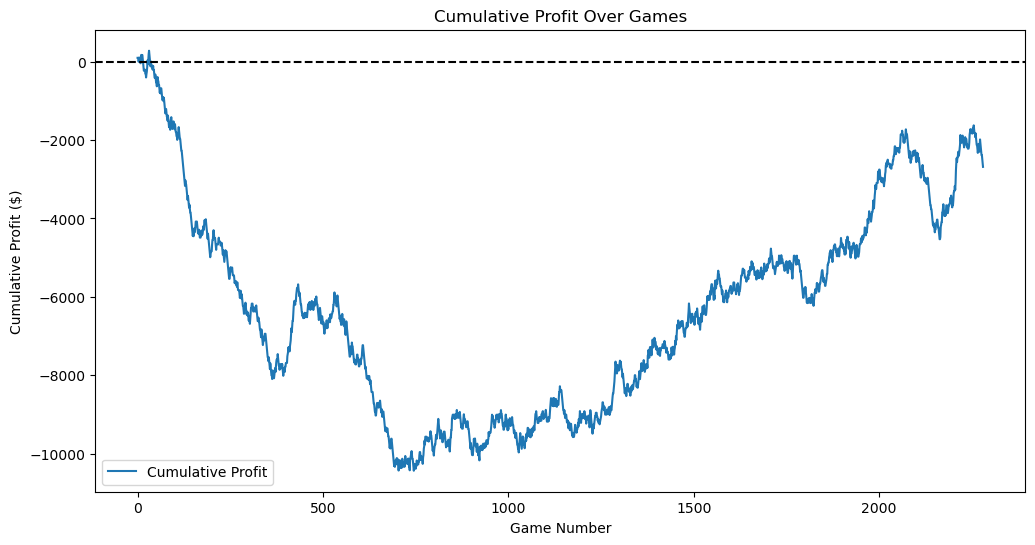

In [277]:
import matplotlib.pyplot as plt

# Assuming 'Profit_cumsum' is already calculated in the DataFrame

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative profit against the game number
ax.plot(evaluation_df['Profit2_cumsum'], label='Cumulative Profit')

# Set labels and title
ax.set_xlabel('Game Number')
ax.set_ylabel('Cumulative Profit ($)')
ax.set_title('Cumulative Profit Over Games')
ax.axhline(0, linestyle = 'dashed', color = 'black')

# Add a legend
ax.legend()

# Show the plot
plt.show()


Well, that didn't work! Instead of betting on all 2,280 games, I only bet on 1,799 games, so my investment was ~\\$48k less than the above strategy, but I actually lost \\$2,683, for an ROI of -1.5%. The graph below shows that this strategy was a loser almost from the very start. At one point it was down more than \\$10k, because clawing back most of those losses.

The fundamental problem with this strategy is that it makes many bets that the model believes I will lose. While I could hope for the expected value of the bets to compensate for that, it is only likely to do so when the predictecd probabilities for both teams are fairly close. If the implied odds suggest that the underdog has only a 25% likelihood of winning the game, but my model believes they have a 27% likelihood, this strategy bets on them, even though I have little expectation that they will actually win. However if my model predicts that the underdog has a 49% chance of winning, I would not be surprised if they won the game. Unfortunately, these are the exact type of games that I wouldn't bet on at all. The odds build in the commission, so a game that the bookmaker believed had a 52%/48% favorite/underdog likelihood would actually have a calculated probability from the odds of something more like 54%/50%. Casinos do not like to offer even money on a coin flip, so they build in their profit! As a result, I skipped betting on those, instead betting on bigger underdogs who, not surprisingly, lost more frequently.

What if I combined the two strategies, and bet on teams that the model predicted would win, but only if the predicted probability exceeded the implied probability?

In [88]:
#dupe
# Create a new column 'Profit3' with default value 0
evaluation_df['Profit3'] = 0

# Condition for team_x winning the bet based on the new criteria
team_x_win_condition = (evaluation_df['Predicted_Probability'] > evaluation_df['Implied_prob']) & (evaluation_df['won'] == 1) & (evaluation_df['Predicted_Probability'] > 0.5)

# Condition for opposingTeam winning the bet based on the new criteria
opp_team_win_condition = ((1 - evaluation_df['Predicted_Probability']) > evaluation_df['Implied_prob_a']) & (evaluation_df['won'] == 0) & (evaluation_df['Predicted_Probability'] <= 0.5)

# Calculate profit for team_x winning the bet
evaluation_df.loc[team_x_win_condition, 'Profit3'] = evaluation_df.loc[team_x_win_condition, 'Odds'].where(
    evaluation_df['Odds'] > 0,
    (100 / evaluation_df['Odds'].abs()) * 100
)

# Calculate profit for opposingTeam winning the bet
evaluation_df.loc[opp_team_win_condition, 'Profit3'] = evaluation_df.loc[opp_team_win_condition, 'Odds_a'].where(
    evaluation_df['Odds_a'] > 0,
    (100 / evaluation_df['Odds_a'].abs()) * 100
)

# Loss for team_x losing the bet
loss_condition_team_x = (evaluation_df['Predicted_Probability'] > evaluation_df['Implied_prob']) & (evaluation_df['won'] == 0) & (evaluation_df['Predicted_Probability'] > 0.5)
evaluation_df.loc[loss_condition_team_x, 'Profit3'] = -100

# Loss for opposingTeam losing the bet
loss_condition_opp_team = ((1 - evaluation_df['Predicted_Probability']) > evaluation_df['Implied_prob_a']) & (evaluation_df['won'] == 1) & (evaluation_df['Predicted_Probability'] <= 0.5)
evaluation_df.loc[loss_condition_opp_team, 'Profit3'] = -100

# Display the updated DataFrame
print(evaluation_df[['gameId', 'team_x', 'opposingTeam', 'won', 'Odds', 'Odds_a', 'Implied_prob', 'Implied_prob_a', 'Predicted_Probability', 'Profit3']])


          gameId team_x opposingTeam  won   Odds  Odds_a  Implied_prob  \
0     2012020015    NYR          PIT  0.0 -110.0  -110.0      0.523810   
1     2012020037    NYR          BOS  1.0 -130.0   110.0      0.565217   
2     2012020058    NYR          TOR  1.0 -180.0   160.0      0.642857   
3     2012020080    NYR          PHI  1.0 -170.0   150.0      0.629630   
4     2012020095    NYR          PIT  0.0 -120.0   100.0      0.545455   
...          ...    ...          ...  ...    ...     ...           ...   
2281  2021021204    DAL          SJS  1.0 -223.0   203.0      0.690402   
2282  2021021255    DAL          SEA  1.0 -310.0   270.0      0.756098   
2283  2021021281    DAL          VGK  1.0 -105.0  -105.0      0.512195   
2284  2021021287    DAL          ARI  0.0 -470.0   385.0      0.824561   
2285  2021021307    DAL          ANA  1.0 -220.0   200.0      0.687500   

      Implied_prob_a  Predicted_Probability     Profit3  
0           0.523810               0.461412   90.9090

In [89]:
# dupe
#calculate cumulative profit
evaluation_df['Profit3_cumsum'] = evaluation_df['Profit3'].cumsum()

In [90]:
#dupe
evaluation_df

,gameId,team_x,opposingTeam,won,Odds,Odds_a,Implied_prob,Implied_prob_a,Predicted_Probability,profit,Profit_cumsum,Profit2,Profit2_cumsum,Profit3,Profit3_cumsum
0,2012020015,NYR,PIT,0.0,-110.0,-110.0,0.523810,0.523810,0.461412,90.909091,90.909091,90.909091,90.909091,90.909091,90.909091
1,2012020037,NYR,BOS,1.0,-130.0,110.0,0.565217,0.476190,0.642619,76.923077,167.832168,76.923077,167.832168,76.923077,167.832168
2,2012020058,NYR,TOR,1.0,-180.0,160.0,0.642857,0.384615,0.439472,-100.000000,67.832168,-100.000000,67.832168,-100.000000,67.832168
3,2012020080,NYR,PHI,1.0,-170.0,150.0,0.629630,0.400000,0.583401,58.823529,126.655697,-100.000000,-32.167832,0.000000,67.832168
4,2012020095,NYR,PIT,0.0,-120.0,100.0,0.545455,0.500000,0.479173,100.000000,226.655697,100.000000,67.832168,100.000000,167.832168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2281,2021021204,DAL,SJS,1.0,-223.0,203.0,0.690402,0.330033,0.339002,-100.000000,997.591918,-100.000000,-8112.056501,-100.000000,-165.056501
2282,2021021255,DAL,SEA,1.0,-310.0,270.0,0.756098,0.270270,0.631965,32.258065,1029.849982,-100.000000,-8212.056501,0.000000,-165.056501
2283,2021021281,DAL,VGK,1.0,-105.0,-105.0,0.512195,0.512195,0.637875,95.238095,1125.088078,95.238095,-8116.818405,95.238095,-69.818405
2284,2021021287,DAL,ARI,0.0,-470.0,385.0,0.824561,0.206186,0.367899,385.000000,1510.088078,385.000000,-7731.818405,385.000000,315.181595


In [91]:
# dupe
# calculate number of games with no bet
(evaluation_df['Profit3'] == 0).sum()

774

This strategy bet on far fewer games, requiring an outlay of only ~\\$89k. It ended up returning \\$4,531, for an ROI of 5.1%. It required a lot of patience, though; it was mostly unprofitable through the first 1,000 games!

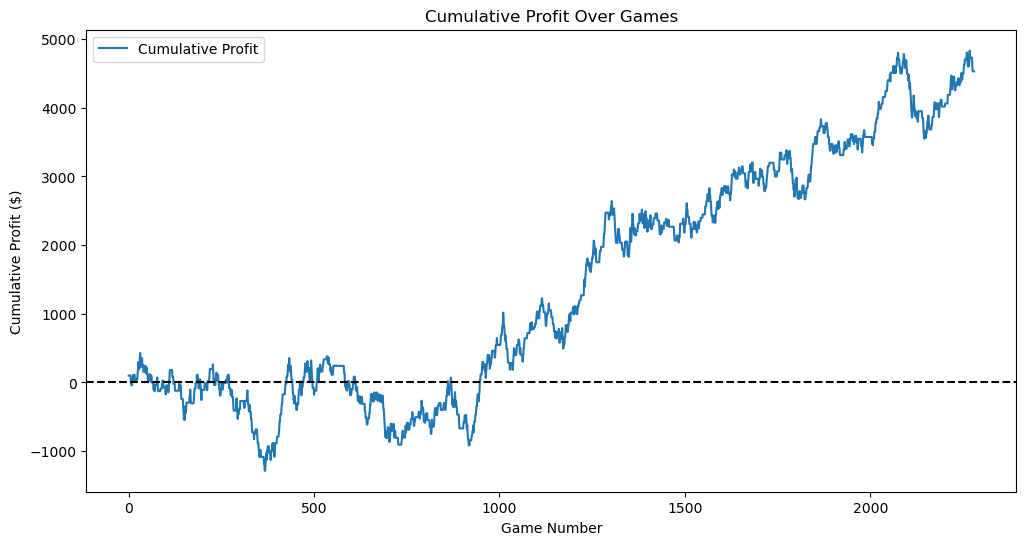

In [284]:
import matplotlib.pyplot as plt

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the cumulative profit against the game number
ax.plot(evaluation_df['Profit3_cumsum'], label='Cumulative Profit')

# Set labels and title
ax.set_xlabel('Game Number')
ax.set_ylabel('Cumulative Profit ($)')
ax.set_title('Cumulative Profit Over Games')
ax.axhline(0, linestyle = 'dashed', color = 'black')

# Add a legend
ax.legend()

# Show the plot
plt.show()

## **Conclusion and Next Steps** <a class="anchor" id="6"></a>

While there remain model optimization opportunities, this exercise has demonstrated that there is the possibility of predicting NHL game outcomes with some degree of accuracy. While ~60% accuracy does not feel impressive, hockey is likely the most unpredictable of the major sports. The fact that strategic betting using the predicted outcomes from my model could potentially generate an ROI of 5% is very impressive. In fact, if I could replicate that consistently, there is likely a business model that such returns could support.

At a high level, such a business could include the standard details of a typical betting site, augmented with my model's  predictions, and recommendations of when to bet. It could link to the user's preferred betting site(s), earning affiliate revenue for each transaction. And if the model continues to prove successful, I could likely also charge a subscription fee for access, meaning there would be multiple possible revenue streams.

Introducing **PuckPredictor**<sup>TM </sup>!

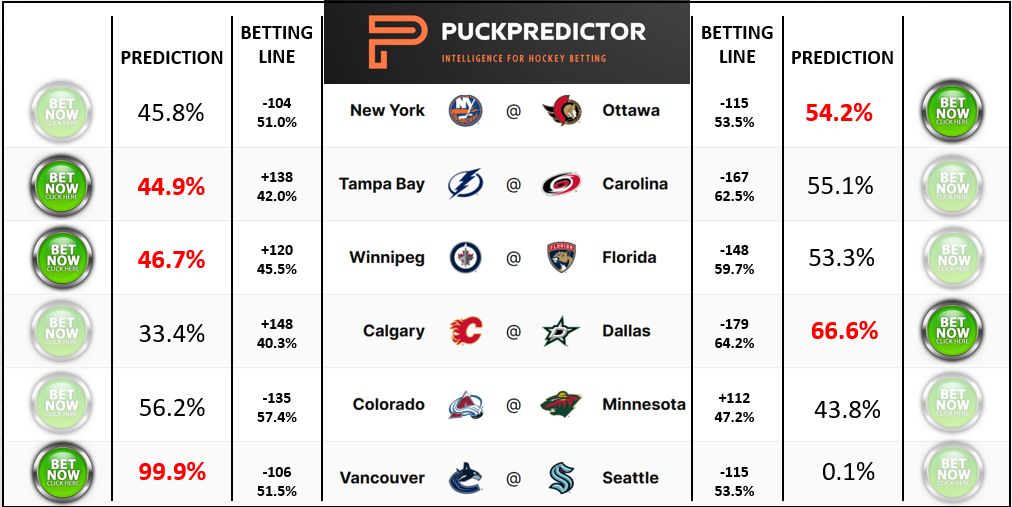